In [179]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from utils import *

import warnings
warnings.filterwarnings('ignore')

# Traffic volume prediction

In [456]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume_reduced.csv')

# Data Exploration and Preparation

In [3]:
data

date_time holiday  weather_main     weather_description  \
0      2016-07-01 00:00:00     NaN         Clear            sky is clear   
1      2016-07-01 01:00:00     NaN         Clear            sky is clear   
2      2016-07-01 02:00:00     NaN         Clear            sky is clear   
3      2016-07-01 03:00:00     NaN         Clear            sky is clear   
4      2016-07-01 04:00:00     NaN         Clear            sky is clear   
...                    ...     ...           ...                     ...   
23617  2018-09-30 19:00:00     NaN        Clouds           broken clouds   
23618  2018-09-30 20:00:00     NaN        Clouds         overcast clouds   
23619  2018-09-30 21:00:00     NaN  Thunderstorm  proximity thunderstorm   
23620  2018-09-30 22:00:00     NaN        Clouds         overcast clouds   
23621  2018-09-30 23:00:00     NaN        Clouds         overcast clouds   

       rain_1h  snow_1h  clouds_all    temp  traffic_volume  
0          0.0      0.0           1  289.04             825  
1          0.0      0.0           1  288.16             531  
2          0.0      0.0           1  286.64             381  
3          0.0      0.0           1  285.39             406  
4          0.0      0.0           1  284.67             790  
...        ...      ...         ...     ...             ...  
23617      0.0      0.0          75  283.45            3543  
23618      0.0      0.0          90  282.76            2781  
23619      0.0      0.0          90  282.73            2159  
23620      0.0      0.0          90  282.09            1450  
23621      0.0      0.0          90  282.12             954  

[23622 rows x 9 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23622 entries, 0 to 23621
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            23622 non-null  object 
 1   holiday              31 non-null     object 
 2   weather_main         23622 non-null  object 
 3   weather_description  23622 non-null  object 
 4   rain_1h              23622 non-null  float64
 5   snow_1h              23622 non-null  float64
 6   clouds_all           23622 non-null  int64  
 7   temp                 23622 non-null  float64
 8   traffic_volume       23622 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB


As we can observe by the information of the info table, the date_time column is represented by an object. We have other three columns in strings, 'holiday', 'weather_main' and 'weather_description'. The rest of the columns are represented either by integers or floats, including the target column that in this case is a integer.
The holiday column is the only one that contains null values, being almost all of them not filled.

In [5]:
data.describe()

rain_1h  snow_1h    clouds_all          temp  traffic_volume
count  23622.000000  23622.0  23622.000000  23622.000000    23622.000000
mean       0.494697      0.0     47.238252    282.525740     3245.343282
std       63.969632      0.0     39.583571     12.400988     1959.766880
min        0.000000      0.0      0.000000    243.390000        0.000000
25%        0.000000      0.0      1.000000    273.420000     1211.000000
50%        0.000000      0.0     40.000000    284.755000     3400.000000
75%        0.000000      0.0     90.000000    292.650000     4878.000000
max     9831.300000      0.0    100.000000    310.070000     7280.000000

We noticed that the maximum amount of rain in an hour is much higher than any acceptable value. This outlier is inflating the standard deviation of the column, as all the quantiles are 0, the mean is less than 1, and the standard deviation is close to 64. Given that all quantiles (25%, 50%, 75%) are 0 and the mean is less than 1, it suggests that the vast majority of the data points have values near or at 0. The extreme value of 9831.3 distorts the overall distribution, creating a high standard deviation and making the column less reliable for analysis.

In the snow_1h column, both the minimum and maximum values are 0, meaning the column only contains a single value—0. This lack of variation makes the column completely unhelpful for predicting traffic volume. Since predictive models require features with multiple values to identify patterns, a column that only contains one value provides no useful information. Therefore, the snow_1h column should be excluded from the analysis as it cannot contribute to the prediction and we are unable to calculate accurate or variable values retrospectively, keeping this column would not be beneficial for the analysis.

The column clouds_all does not seem to have any anomalies. It represents a percentage, and all its values fall within the expected 0 to 100 range. Upon examining the summary statistics, we can see that the minimum value is 0, the maximum value is 100, and the mean is approximately 47.24. The 25th percentile (1%) and the 50th percentile (40%) are fairly close to the mean, indicating that the distribution is relatively centered around the middle. Additionally, the standard deviation (39.58) suggests moderate spread, but there are no extreme variations or outliers. The fact that the mean and second quantile values are close to each other further supports that the data is not skewed.

The temperature column does not show significant anomalies. The values range from 243.39 to 310.07, indicating a broad span of temperatures. The mean value of 282.53 is indicative of the overall central tendency, and the 25th percentile (273.42) and 50th percentile (284.76) show that the majority of the data points are clustered within a relatively narrow range between these values. The 75th percentile (292.65) indicates that most values fall below this point, with fewer observations at the higher end of the scale. The standard deviation of 12.4 suggests moderate variability, which is consistent with the observed spread of values. There are no extreme outliers, and the data appears to have a balanced distribution, as evidenced by the relatively close proximity of the mean, 25th percentile, and 50th percentile. The overall distribution is not highly skewed.

In the traffic_volume column the values range from 0 to 7280, which is the biggest interval out of all columns, excluding the outlier in the rain_1h column. Since the median is relatively closer to the third quantile than the first, we can conclude that the data is positively skewed. This claim is supported by the fact that the maximum value is much higher than the third quantile. Since the mean and the median are relatively close to each other we can conclude that the skewness of the data is not very large. The standard deviation is very high confirming a high degree of dispersion in the data.


In [6]:
data.describe(include='object')

date_time    holiday weather_main weather_description
count                 23622         31        23622               23622
unique                19608         11           11                  37
top     2018-09-20 18:00:00  Labor Day        Clear        sky is clear
freq                      5          5         7027                6268

It is visible that the date_time column has repeated values. This was not expected as the data was supposed to have continuous observations without gaps. We will deal with that later on.

Since we have 11 different holidays and only 31 rows represent a non-null value, we decided to take a look on the values since the dataset has 24 different values for each day, which means that we should have a lot more filled values. We discovered that only the first hour of the holiday was correctly filled. We will fill in the values accordingly later.

The most frequent value in the weather-main column is "Clear" appearing in almost 1/3 of the rows. We will check the different possibilities of the values.

In the weather_description column there are 37 different descriptions, with the most frequent one appearing 6268 times. Since it appears that t describes the situation presented in the previous column and given the fact that the frequency of the values are so close, we will check how these two columns correlate.


In [7]:
# Verifying if there are any missing values in the data

data.isna().sum()

date_time                  0
holiday                23591
weather_main               0
weather_description        0
rain_1h                    0
snow_1h                    0
clouds_all                 0
temp                       0
traffic_volume             0
dtype: int64

This confirms our earlier observation that the holiday column contains a significant number of null values due to the absence of a holiday on most dates. To address this, we will assign a placeholder value, such as "No holiday," to indicate that a given day does not correspond to any holiday.
On the other hand, all other columns are complete and do not contain any missing values.

In [8]:
# Assigning the new value to the holiday column

data['holiday'] = data['holiday'].fillna('No holiday')

In [9]:
# Checking if there are any duplicated values

data.duplicated().sum()

15

In [10]:
# Removing the duplicate values

data.drop_duplicates(inplace=True)

In [11]:
# Transforming the 'date_time' column to correctly represent dates and check the interval of the dataset observations

data['date_time'] = pd.to_datetime(data['date_time'])

date_min = data['date_time'].min().date()
date_max = data['date_time'].max().date()

print(f'The study dates of our work are from {date_min} to {date_max}.')

The study dates of our work are from 2016-07-01 to 2018-09-30.


Now we will address the outlier we detected earlier.

In [12]:
# Check the row of the outlier

data[data['rain_1h'] == data['rain_1h'].max()]

date_time     holiday weather_main weather_description  rain_1h  \
290 2016-07-11 17:00:00  No holiday         Rain     very heavy rain   9831.3   

     snow_1h  clouds_all    temp  traffic_volume  
290      0.0          75  302.11            5535

To substitute the value of rain with a suitable value, we will analyze the weather conditions for the corresponding day to determine an appropriate replacement.

In [13]:
# Filtering the data to show the rows of the day with the maximum rain value

filtered_data = data[data['date_time'].dt.date == pd.to_datetime('2016-07-11').date()]
filtered_data

date_time     holiday  weather_main  \
273 2016-07-11 00:00:00  No holiday        Clouds   
274 2016-07-11 01:00:00  No holiday        Clouds   
275 2016-07-11 02:00:00  No holiday        Clouds   
276 2016-07-11 03:00:00  No holiday        Clouds   
277 2016-07-11 04:00:00  No holiday        Clouds   
278 2016-07-11 05:00:00  No holiday        Clouds   
279 2016-07-11 06:00:00  No holiday          Rain   
280 2016-07-11 07:00:00  No holiday          Rain   
281 2016-07-11 08:00:00  No holiday          Rain   
282 2016-07-11 09:00:00  No holiday        Clouds   
283 2016-07-11 10:00:00  No holiday  Thunderstorm   
284 2016-07-11 11:00:00  No holiday  Thunderstorm   
285 2016-07-11 12:00:00  No holiday          Rain   
286 2016-07-11 13:00:00  No holiday  Thunderstorm   
287 2016-07-11 14:00:00  No holiday        Clouds   
288 2016-07-11 15:00:00  No holiday  Thunderstorm   
289 2016-07-11 16:00:00  No holiday  Thunderstorm   
290 2016-07-11 17:00:00  No holiday          Rain   
291 2016-07-11 18:00:00  No holiday  Thunderstorm   
292 2016-07-11 19:00:00  No holiday        Clouds   
293 2016-07-11 20:00:00  No holiday  Thunderstorm   
294 2016-07-11 21:00:00  No holiday  Thunderstorm   
295 2016-07-11 22:00:00  No holiday          Rain   
296 2016-07-11 23:00:00  No holiday  Thunderstorm   
297 2016-07-11 23:00:00  No holiday          Rain   

              weather_description  rain_1h  snow_1h  clouds_all    temp  \
273               overcast clouds     0.00      0.0          90  296.22   
274               overcast clouds     0.00      0.0          90  295.80   
275               overcast clouds     0.00      0.0          90  295.62   
276                 broken clouds     0.00      0.0          75  295.24   
277                 broken clouds     0.00      0.0          75  295.40   
278                 broken clouds     0.00      0.0          75  295.37   
279                    light rain     0.00      0.0          90  295.05   
280                    light rain     0.00      0.0          75  294.99   
281                    light rain     0.00      0.0          90  294.83   
282               overcast clouds     0.00      0.0          90  294.79   
283        proximity thunderstorm     0.00      0.0          90  295.13   
284        proximity thunderstorm     0.00      0.0          90  296.45   
285                    light rain     0.00      0.0          90  297.73   
286        proximity thunderstorm     0.00      0.0          75  299.15   
287               overcast clouds     0.00      0.0          90  300.18   
288        proximity thunderstorm     0.00      0.0          75  300.81   
289        proximity thunderstorm     0.00      0.0          75  301.48   
290               very heavy rain  9831.30      0.0          75  302.11   
291        proximity thunderstorm     0.00      0.0          75  302.54   
292                 broken clouds     0.00      0.0          75  302.39   
293                  thunderstorm     0.00      0.0          75  302.45   
294  thunderstorm with light rain     0.00      0.0          75  301.70   
295                    light rain     0.51      0.0          75  300.35   
296        proximity thunderstorm     0.00      0.0          90  299.61   
297                    light rain     0.00      0.0          90  299.61   

     traffic_volume  
273             621  
274             376  
275             291  
276             342  
277             848  
278            2780  
279            5211  
280            5803  
281            5157  
282            4016  
283            3891  
284            3998  
285            4273  
286            4475  
287            4456  
288            4858  
289            5934  
290            5535  
291            3900  
292            2856  
293            2506  
294            2062  
295            1544  
296             995  
297             995

Since no other occurrence of the day reported values on the rain_1h column, we need to find another approach to substite the value.
We will check the second largest rain value to check if both rows have similar values.

In [14]:
# Filtering the data to look for the second largest rain value

second_larget = data['rain_1h'].sort_values(ascending=False).iloc[1]
data[data['rain_1h'] == second_larget]

date_time     holiday weather_main weather_description  \
1197 2016-08-16 17:00:00  No holiday         Rain     very heavy rain   

      rain_1h  snow_1h  clouds_all    temp  traffic_volume  
1197    31.75      0.0           0  297.71            4913

Since both rows reported 'very heavy rain' under similar temperatures, we will replace the outlier value by this one.

In [15]:
# Replacing the outlier value with a suitable one

data['rain_1h'].replace(9831.3, second_larget, inplace=True)

We noticed that there are rows with the same date and time. We will check these columns to try to find a solution for them.

In [16]:
# Get duplicated dates
duplicates = data.index[data.index.duplicated(keep=False)]
unique_duplicates = data.loc[duplicates].drop_duplicates()
unique_duplicates

Empty DataFrame
Columns: [date_time, holiday, weather_main, weather_description, rain_1h, snow_1h, clouds_all, temp, traffic_volume]
Index: []

The rows have the same numerical values but report different weather conditions. Since these conditions may impact traffic in varying ways, we have decided to retain the weather condition that has the greatest potential to affect traffic, taking into account factors such as visibility, road conditions, and other relevant weather elements. We settled on the following ranking of priorities that will be assigned to every row based on the weather condition it registered. Wen encountering duplicated dates we will keep the row that has the lowest priority value and drop the rest.

In [17]:
# Define the priority order for traffic impact and drop the rows with duplicated dates

weather_impact_priority = {
    'Thunderstorm': 1, 'Snow': 2, 'Rain': 3, 
    'Drizzle': 4, 'Fog': 5, 'Haze': 6, 
    'Clouds': 7, 'Mist': 8, 'Smoke': 9, 
    'Squall': 10, 'Clear': 11
}

data['weather_priority'] = data['weather_main'].map(weather_impact_priority)

data = data.sort_values(by=['date_time', 'weather_priority'])

data = data.drop_duplicates(subset='date_time', keep='first')

data.drop(columns=['weather_priority'], inplace=True)

We also noticed that some combinations of the date and time are missing. We will create the rows and fill the missing values using the backward fill technique.

In [18]:
# Transform the date_time column into the index after creating the missing rows and filling them

data = data.set_index('date_time')

new_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

data = data.reindex(new_index)

data.index.freq = 'H'

data = data.fillna(method='bfill')

Since the temperature is represented in Kelvin, we will transform it into Celsius to be interpreted easily.

In [19]:
# Converting Kelvin to Celsius

data['temp']= data['temp'] - 273.15

To address the issue of the holiday value only appearing at midnight on the respective day, we will identify all rows corresponding to holidays and propagate the holiday values throughout the entire day. Specifically, we will iterate through the dataset to find each row that represents a holiday, extract the corresponding date, and assign the holiday value to all rows matching that date.

In [20]:
# Assigning the holiday values correctly

def update_holiday(data):
    for index, row in data.iterrows():
        if row['holiday'] != 'No holiday':
            # Extract the date part from the index
            date = index.date()
            
            # Update the 'holiday' column for all rows with the same date
            data.loc[data.index.date == date, 'holiday'] = row['holiday']
            
update_holiday(data)

In [21]:
# Final look of our corrected dataset

data

holiday  weather_main     weather_description  \
2016-07-01 00:00:00  No holiday         Clear            sky is clear   
2016-07-01 01:00:00  No holiday         Clear            sky is clear   
2016-07-01 02:00:00  No holiday         Clear            sky is clear   
2016-07-01 03:00:00  No holiday         Clear            sky is clear   
2016-07-01 04:00:00  No holiday         Clear            sky is clear   
...                         ...           ...                     ...   
2018-09-30 19:00:00  No holiday        Clouds           broken clouds   
2018-09-30 20:00:00  No holiday        Clouds         overcast clouds   
2018-09-30 21:00:00  No holiday  Thunderstorm  proximity thunderstorm   
2018-09-30 22:00:00  No holiday        Clouds         overcast clouds   
2018-09-30 23:00:00  No holiday        Clouds         overcast clouds   

                     rain_1h  snow_1h  clouds_all   temp  traffic_volume  
2016-07-01 00:00:00      0.0      0.0         1.0  15.89           825.0  
2016-07-01 01:00:00      0.0      0.0         1.0  15.01           531.0  
2016-07-01 02:00:00      0.0      0.0         1.0  13.49           381.0  
2016-07-01 03:00:00      0.0      0.0         1.0  12.24           406.0  
2016-07-01 04:00:00      0.0      0.0         1.0  11.52           790.0  
...                      ...      ...         ...    ...             ...  
2018-09-30 19:00:00      0.0      0.0        75.0  10.30          3543.0  
2018-09-30 20:00:00      0.0      0.0        90.0   9.61          2781.0  
2018-09-30 21:00:00      0.0      0.0        90.0   9.58          2159.0  
2018-09-30 22:00:00      0.0      0.0        90.0   8.94          1450.0  
2018-09-30 23:00:00      0.0      0.0        90.0   8.97           954.0  

[19728 rows x 8 columns]

## Univariate Analysis

In [22]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

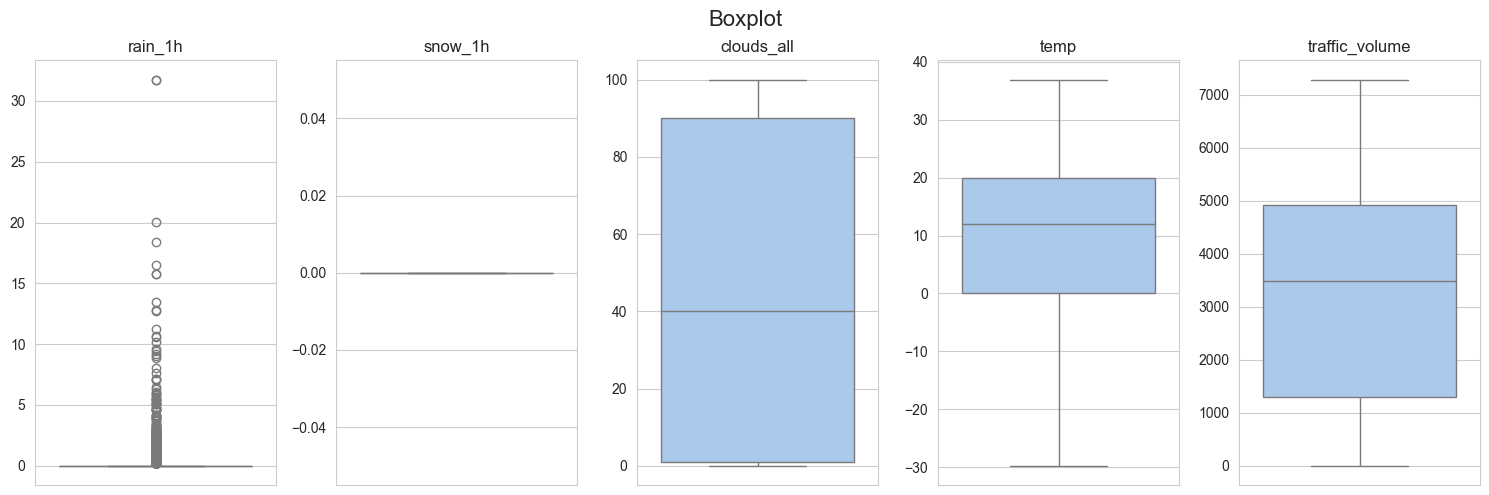

In [23]:
boxplot_visualization(data, numerical_columns, "Boxplot")

We decided to analyse the distribution of the numerical columns using boxplots.

The column rain_1h contains the majority of its values of 0, as indicated by the fact that all the quartiles of the box plot are at the 0 mark. This suggests that no rainfall is the most common condition. Additionally, a significant number of outliers can be observed, which is expected because it is rarer to have rainfall than to have none. Among these outliers, one value stands out as an extreme case, being far apart from the others. This outlier likely corresponds to an instance of extreme weather, as previously observed.

Since all the values in the snow_1h column are 0, the maximum, minimum, and all quantiles correspond to that number. As the values are constant, this column does not contain any outliers and provides no variability. Therefore, it does not offer meaningful insights or contribute to understanding the data.

We can observe that the box in the clouds_all plot is very large, which indicates that the data is spread out and exhibits high variability. The absence of outliers suggests that the extreme values are close to the interquartile range. Additionally, the slight skew in the data indicates that lower values are marginally more common than higher ones.

The box of the temp column suggests that the most frequent values fall within the 0 to 20 degrees range, with the median being close to 11°C, which can be considered a normal temperature. Since the range between the second and third quartiles is smaller than the range between the first and second quartiles, we can deduce that the upper values are more clustered than the lower ones. This is also evident from the fact that the lower extremes of temperature are further from the box than the upper extremes, indicating a slight skew toward lower temperatures. The relatively long whiskers suggests that there are some big deviations from the expected temperature values, likely due to extreme weather conditions that do not appear very often.

The last plot we can see that the data has high variability, with values ranging from 0 to nearly 7500. Since the median is close to the middle of the range, it suggests the data is fairly balanced. However, the plot also shows a slight right skew, meaning there are more lower traffic volumes than higher ones, as seen by the upper whisker extending farther from the box. This is further confirmed by the larger gap between the first and second quartiles, indicating that most traffic volume values are concentrated in the lower range, with fewer high traffic volume days.
This means that on most days, traffic volumes are relatively low, and high-traffic days are less frequent.

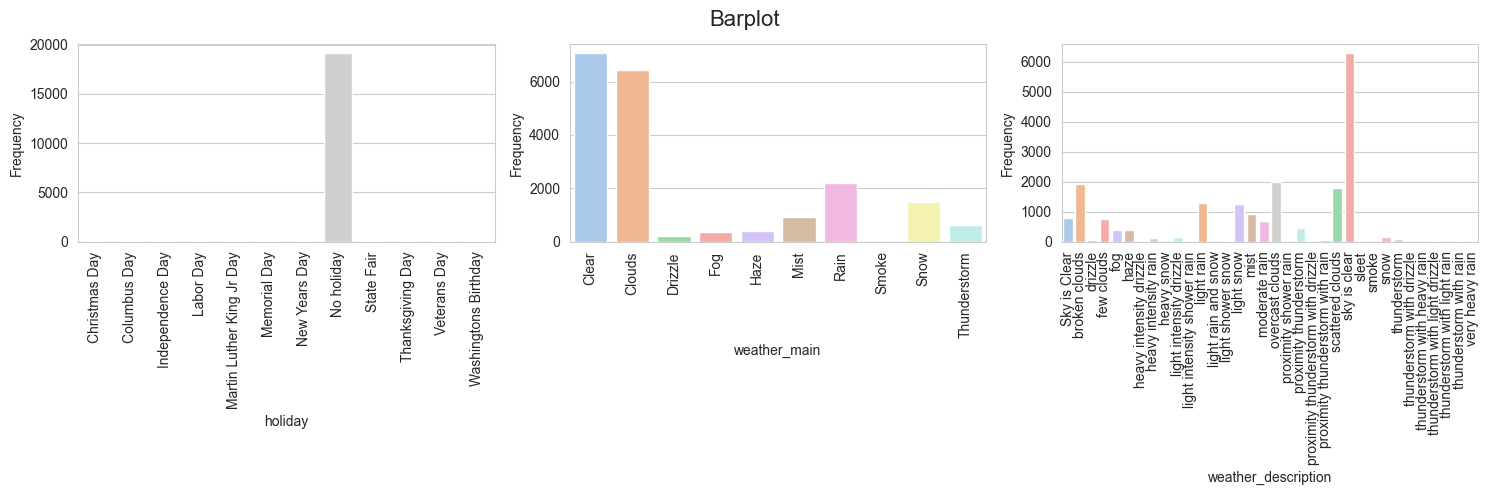

In [24]:
barplot_visualization(data, categorical_columns, "Barplot")

The barplot of the frequency of the holidays shows that 'No holiday' is by far the most frequent value. Since its frequency is so much larger than the other ones, we are unable to see the values for the other holidays. To fix this we need to make another visualization without including the 'No holiday' value.

We can observe that the most frequent weather conditions are 'Clear' and 'Clouds,' which have significantly more recorded values compared to all other options. This is expected, as mild weather conditions are typically the most common. 'Rain' appears slightly more often than the remaining weather types, while 'Smoke' has very few occurrences, making it one of the least frequent conditions. We can also conclude that the distribution is logical, as extreme weather conditions, such as 'Smoke' or 'Squall,' occur far less frequently than mild conditions like 'Clear' or 'Clouds,' which dominate the dataset.

After seeing all the possible weather conditions we noticed that a phrase is appearing twice due to an inconsistent use of capital letters. The most frequent descriptions correspond to the most frequent weather conditions: 'Sky is clear' and 'Sky is Clear' correspond to the 'Clear' weather condition and the sum of its frequencies totals the number that is visible on the previous plot. The next most frequent labels describe the 'Clouds' weather and total its frequency. The ones that appear less refer to more extreme environments that are rarer.

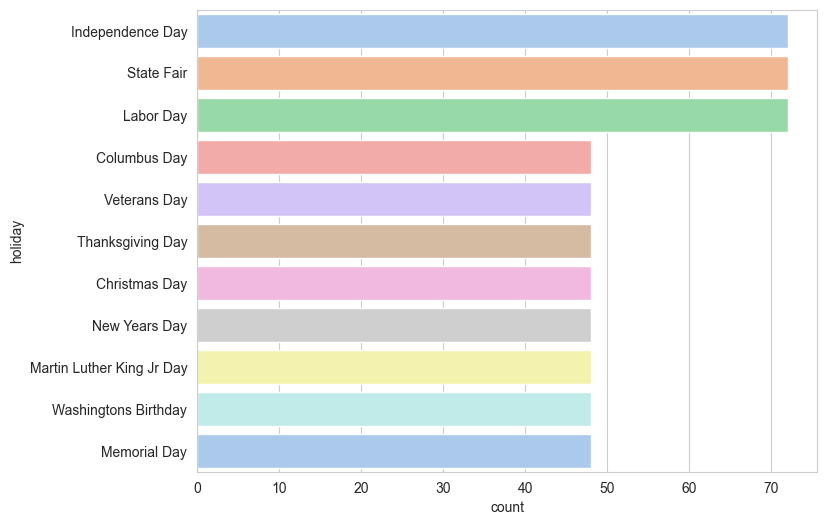

In [25]:
holidays = data.loc[data['holiday'] != 'No holiday']
plt.figure(figsize=(15,5))
sns.countplot(y='holiday', data=holidays, palette='pastel')
plt.show()

Since the dataset's time interval is approximately two years and two months it is no surprise that most of the holidays have a count of 48, meaning that they occurred two times in the study interval given the fact that the observations are made hourly. Only three holidays happened 3 times, totaling 72 registers on the dataset.

## Bivariate Analysis

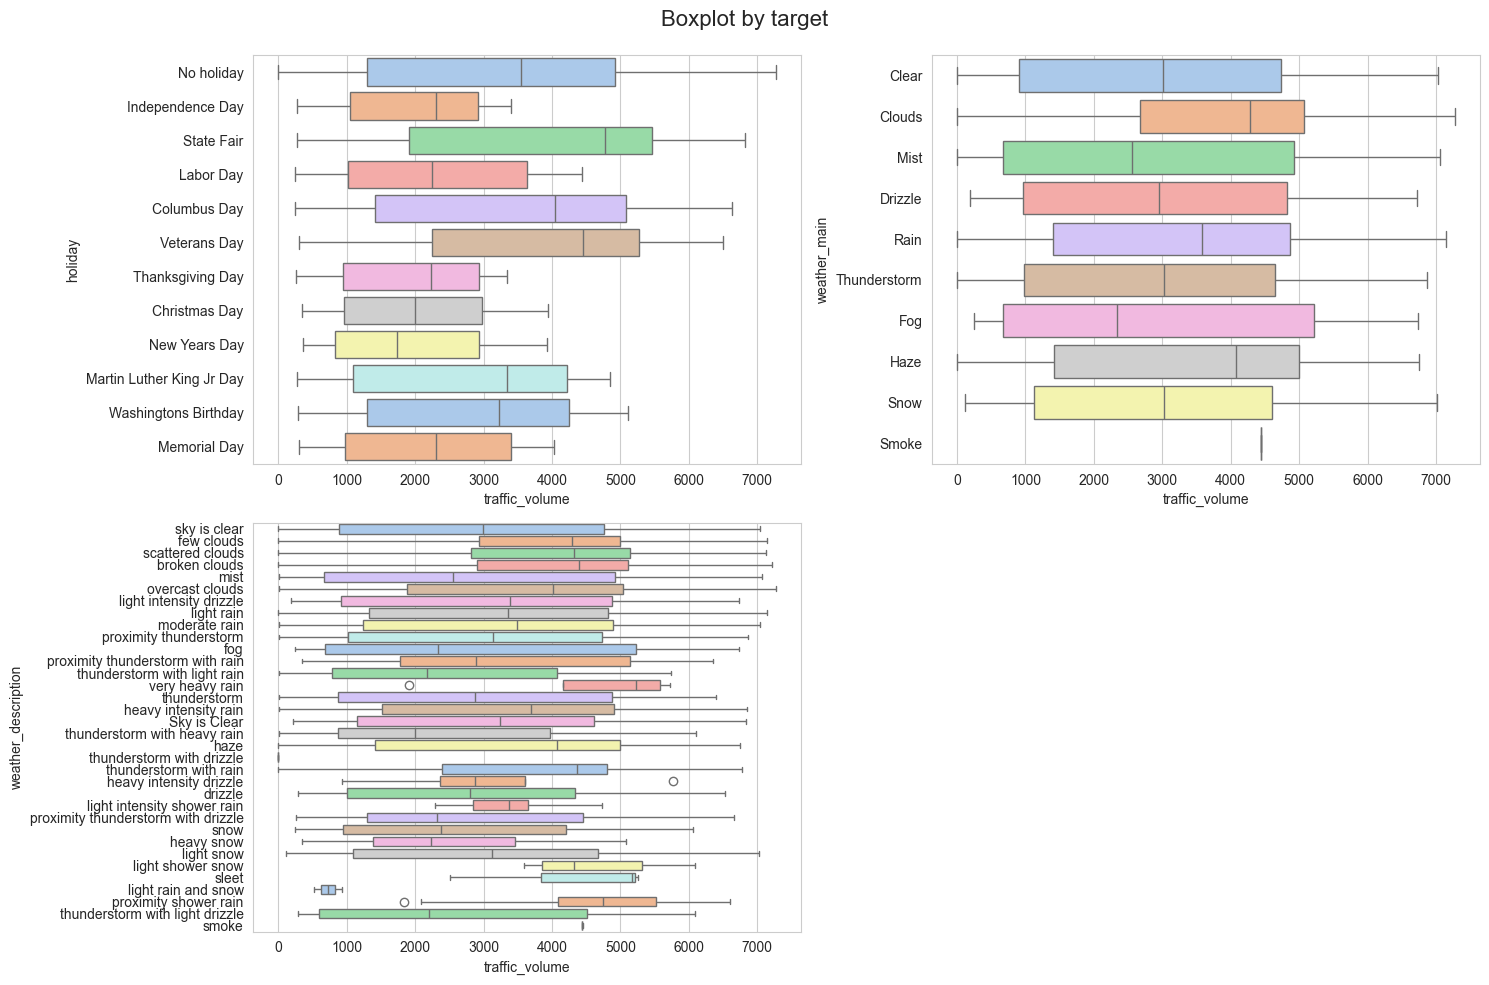

In [26]:
boxplot_by_type_visualization(data, categorical_columns, "Boxplot by target")

The first boxplot shows the distribution of the traffic volume considering each different holiday. The majority of the holidays cover a large range of numbers. No holiday, State fair, Colombus Day and Veterans Days have the highest maximums of traffic out of all holidays and also the bigger boxes with medians of 3500 and above, a high number when comparing with other holidays. Every option has similar minimums, all close to 0. Some boxes have similar values of the first quantile, median and third quantile as is the case for Independence Day, Thanksgiving, Christmas, New Years. By looking at the graph we can tell that only by this column it is not possible to narrow the traffic volume without other information, meaning that this column may not be a good predictor.

When looking at the distribution of the traffic grouping by the weather condition we can see that most of the boxes are very similar, having minimum values close to 0, and maximum ones close to 7000 and half of them has a median close to 3000. A clear exception is the 'Clouds' and 'Smoke' boxes, since the first one is very narrow compared to the others and has the highest median. The second excpetion id due to few 'Smoke' registers on the dataset that causes the quantiles to be on top of each other and the non existence of whiskers. With so few unique distributions we can say that the traffic is not only dependent on the weather since having and extreme weather does not necessarily lead to more traffic as well as having clear one does not lead to less traffic. All boxes except the last one have a bigger whisker on the higher values of traffic indicating that it is less frequent that having fewer traffic. 

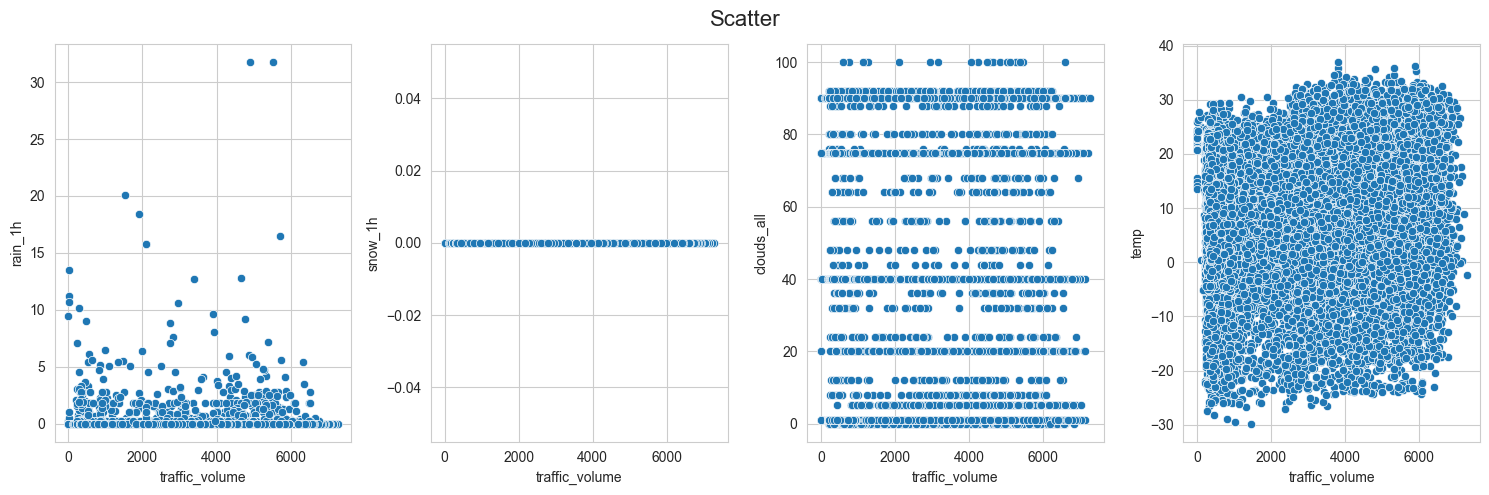

In [27]:
scatter_by_type_visualization(data, numerical_columns, title='Scatter')

Looking at the first graph we were not able to find a connection between the rain and traffic. When there is no registered rain, which happens the majority of the time, the traffic ranges from 0 to 7000. As the amount of rain increases, the amount of values decreases, havning only some occurrences, some with high traffic and some with few.

The snow graph is constant, so we will not analyse it since it does not provide any useful information.

All different values of the clouds_all and temperature columns have occurrences with high and low traffic.

We think that all the previous columns will not be good indicators of the traffic volume.

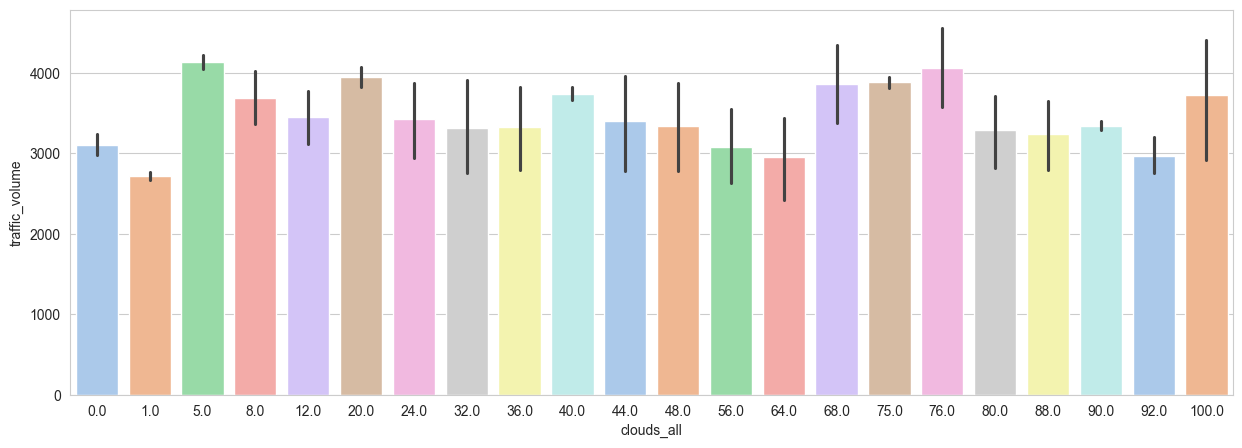

In [36]:
plt.figure(figsize=(15,5))
sns.barplot(x='clouds_all', y='traffic_volume', data=data,palette='pastel')
plt.show()

Observing the graph above we can see that different amounts of clouds tend to have different traffic volume averages. The values can range from 2800 to close to 4000. Although it seems to have a slight increase of traffic for some cloud levels, the relationship is not apparent and is likely due to the different frequency in which the values appear.

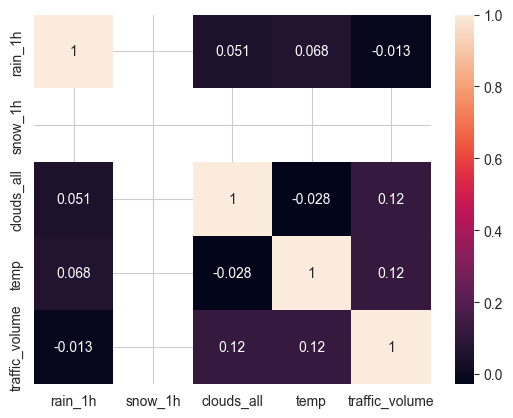

In [39]:
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True)
plt.show()

using the information of the correlation matrix we were able to confirm our suspicions that the columns may not be good indicator of the traffic as they all have low correlations with the target column.

## Visualize traffic by date

In [ ]:
daily_avg = data.resample('D')['traffic_volume'].mean()

plt.figure(figsize=(25, 5))
daily_avg.plot(title='Daily Average Traffic Volume')
plt.ylabel('Traffic Volume')
plt.xlabel('Daily')
plt.show()

In [ ]:
month_avg = data.resample('M')['traffic_volume'].mean()

plt.figure(figsize=(25, 5))
month_avg.plot(title='Month Average Traffic Volume')
plt.ylabel('Traffic Volume')
plt.xlabel('Month')
plt.show()

## Resolve inconsistencies

Independence Day : 04-07
State Fair: occore durante varios dias
Labor Day: priemria segunda feira de setembro
Columbus Day: segunda segunda feira de outubro
Veterans Day: 11-11
Thanksgiving Day: quarta quinta-feira de novembro
Christmas Day: 25-12
New Years Day: 01-01
Martin Luther King Jr Day: terceira segunda-feira de janeiro
Washingtons Birthday: Terceira segunda-feira de fevereiro.


para as datas que nunca mudao dependo do ano, vamos ver se estas estao certas.

In [ ]:
data[(data['holiday'] == 'Independence Day') & ((data.index.month != 7) | (data.index.day != 4))]

In [ ]:
data[(data['holiday'] == 'Veterans Day') & ((data.index.month != 11) | (data.index.day != 11))]

como o dia esta mal marcado iremos alterara para a data certa

In [ ]:
date = pd.to_datetime('2017-11-10').date()
data.loc[data.index.date == date, 'holiday'] = 'No holiday'

date = pd.to_datetime('2017-11-11').date()
data.loc[data.index.date == date, 'holiday'] = 'Veterans Day'

In [ ]:
data[(data['holiday'] == 'Christmas Day') & ((data.index.month != 12) | (data.index.day != 25))]

In [ ]:
date = pd.to_datetime('2016-12-26').date()
data.loc[data.index.date == date, 'holiday'] = 'No holiday'

date = pd.to_datetime('2016-12-25').date()
data.loc[data.index.date == date, 'holiday'] = 'Christmas Day'

In [ ]:
data[(data['holiday'] == 'New Years Day') & ((data.index.month != 1) | (data.index.day != 1))]

In [ ]:
date = pd.to_datetime('2017-01-02').date()
data.loc[data.index.date == date, 'holiday'] = 'No holiday'

date = pd.to_datetime('2017-01-01').date()
data.loc[data.index.date == date, 'holiday'] = 'New Years Day'

In [40]:
data

holiday  weather_main     weather_description  \
2016-07-01 00:00:00  No holiday         Clear            sky is clear   
2016-07-01 01:00:00  No holiday         Clear            sky is clear   
2016-07-01 02:00:00  No holiday         Clear            sky is clear   
2016-07-01 03:00:00  No holiday         Clear            sky is clear   
2016-07-01 04:00:00  No holiday         Clear            sky is clear   
...                         ...           ...                     ...   
2018-09-30 19:00:00  No holiday        Clouds           broken clouds   
2018-09-30 20:00:00  No holiday        Clouds         overcast clouds   
2018-09-30 21:00:00  No holiday  Thunderstorm  proximity thunderstorm   
2018-09-30 22:00:00  No holiday        Clouds         overcast clouds   
2018-09-30 23:00:00  No holiday        Clouds         overcast clouds   

                     rain_1h  snow_1h  clouds_all   temp  traffic_volume  
2016-07-01 00:00:00      0.0      0.0         1.0  15.89           825.0  
2016-07-01 01:00:00      0.0      0.0         1.0  15.01           531.0  
2016-07-01 02:00:00      0.0      0.0         1.0  13.49           381.0  
2016-07-01 03:00:00      0.0      0.0         1.0  12.24           406.0  
2016-07-01 04:00:00      0.0      0.0         1.0  11.52           790.0  
...                      ...      ...         ...    ...             ...  
2018-09-30 19:00:00      0.0      0.0        75.0  10.30          3543.0  
2018-09-30 20:00:00      0.0      0.0        90.0   9.61          2781.0  
2018-09-30 21:00:00      0.0      0.0        90.0   9.58          2159.0  
2018-09-30 22:00:00      0.0      0.0        90.0   8.94          1450.0  
2018-09-30 23:00:00      0.0      0.0        90.0   8.97           954.0  

[19728 rows x 8 columns]

## Encoding data

In [63]:
label_encoder = LabelEncoder()
data_encoded = data.copy()
for col in data.select_dtypes(include='object').columns:
    data_encoded[col] = label_encoder.fit_transform(data[col])

In [65]:
data_encoded.drop(columns= ['snow_1h'], inplace=True)

## Stationary

In [79]:
result = adfuller(data_encoded['traffic_volume'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if ADF_result[1] > 0.05:
    print('not stationary')
else:
    print('stationary')
print(f'Número de lags utilizados: {result[2]}')


ADF Statistic: -17.688426491080936
p-value: 3.581450520708116e-30
stationary
Número de lags utilizados: 45
Número de observações: 19682
Valores críticos:


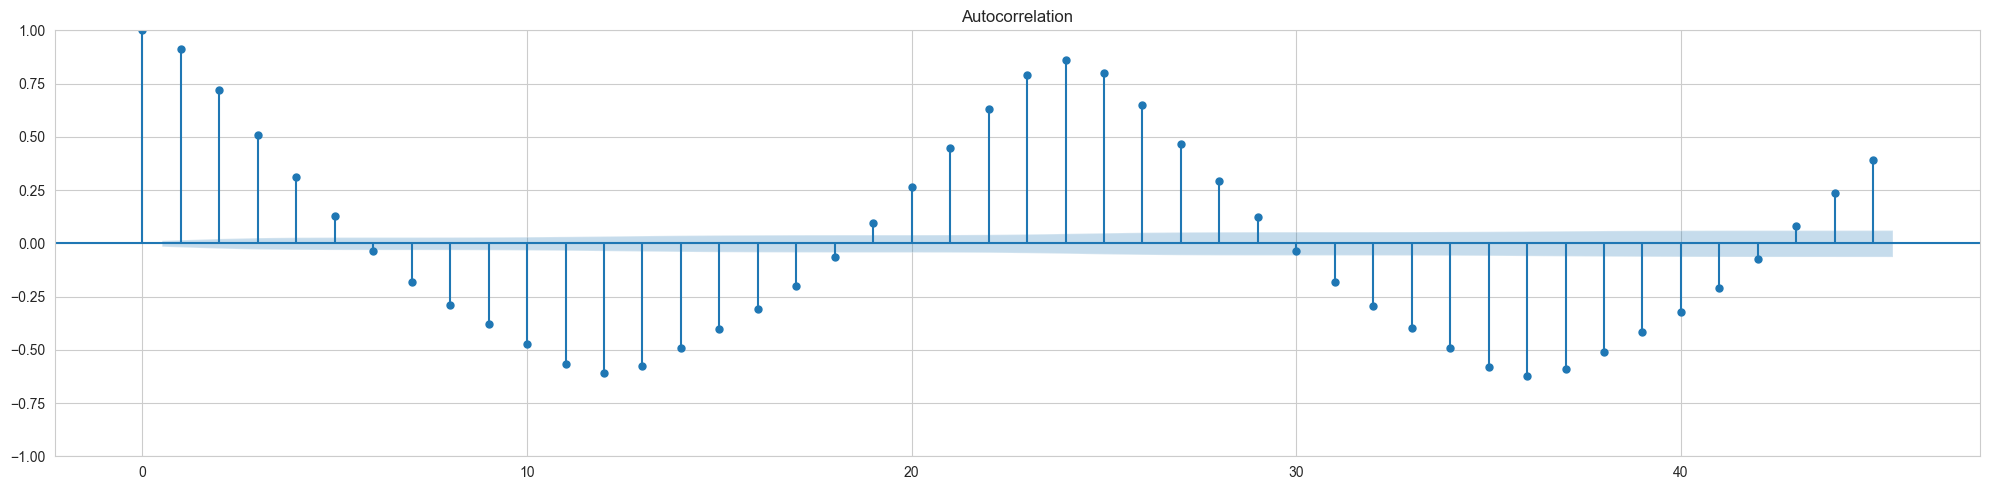

In [101]:
traffic_volume = data_encoded['traffic_volume']
plot_acf(traffic_volume, lags=45)
plt.tight_layout()

The plot shows a significant sinusoidal pattern with a periodicity, indicating strong seasonal behavior. The slow decay in the autocorrelations suggests a non-stationary series with periodic fluctuations.

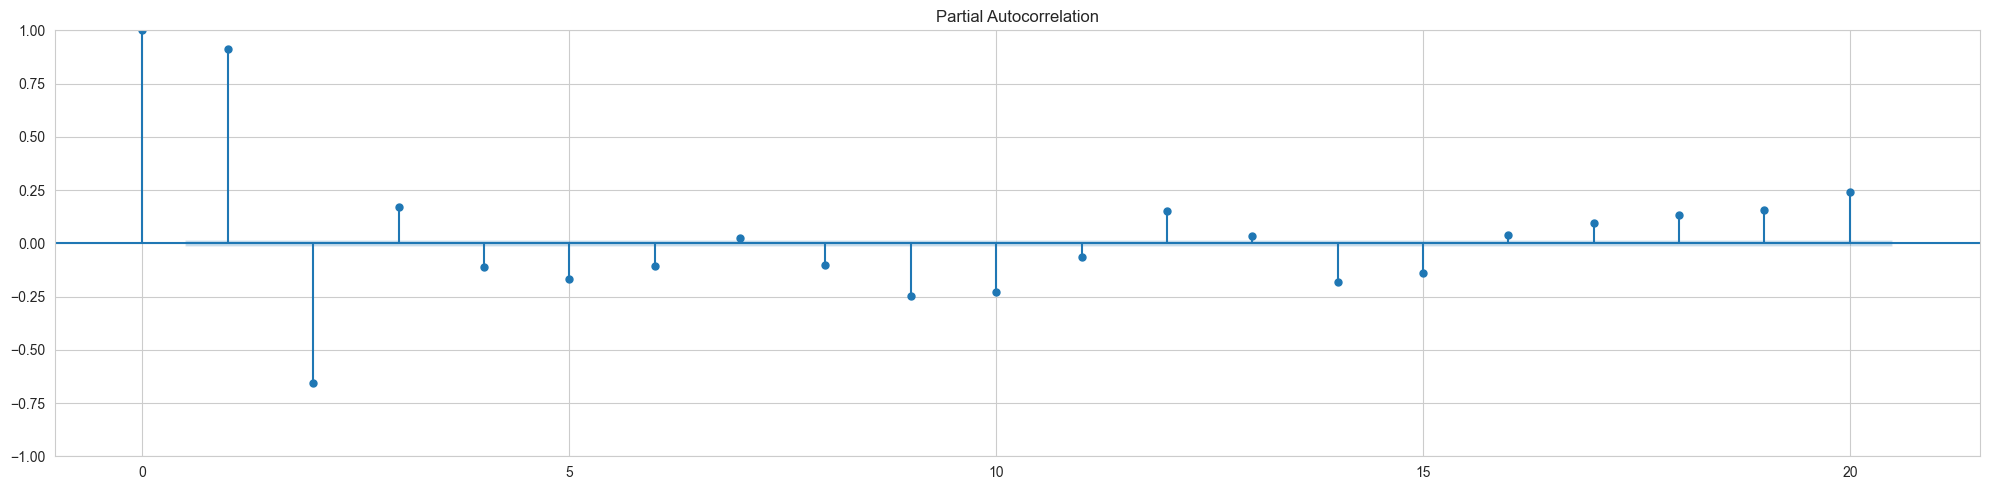

In [100]:
plot_pacf(traffic_volume, lags=20);
plt.tight_layout()

# Create Models

## Statistical Models

iremos usar o modelo arma uma vez que nao conseguimos

In [127]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [128]:
def optimize_ARMA(data, order_list):
    results = []
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [162]:
train = traffic_volume[:-72]
test = traffic_volume[-72:]
test = test.to_frame()

In [180]:
from itertools import product

ps = range(0,6, 1)
qs = range(0,29, 1)
order_list = list(product(ps,qs))

result = optimize_ARMA(train, order_list)
result

(p,q)            AIC
0    (5, 28)  299771.621690
1    (5, 27)  299837.561641
2    (4, 26)  299851.930879
3    (5, 25)  299854.066423
4    (5, 26)  299868.248848
..       ...            ...
169  (0, 27)  358954.737457
170  (0, 22)  358977.240773
171  (0, 25)  359002.319403
172  (0, 19)  359695.759912
173   (0, 0)  380144.560880

[174 rows x 2 columns]

                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                19656
Model:              SARIMAX(5, 0, 28)   Log Likelihood             -149851.811
Date:                Thu, 19 Dec 2024   AIC                         299771.622
Time:                        10:25:40   BIC                         300039.750
Sample:                    07-01-2016   HQIC                        299859.419
                         - 09-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9382      0.102     18.988      0.000       1.738       2.138
ar.L2         -1.7863      0.236     -7.553      0.000      -2.250      -1.323
ar.L3          1.6093      0.275      5.860      0.0

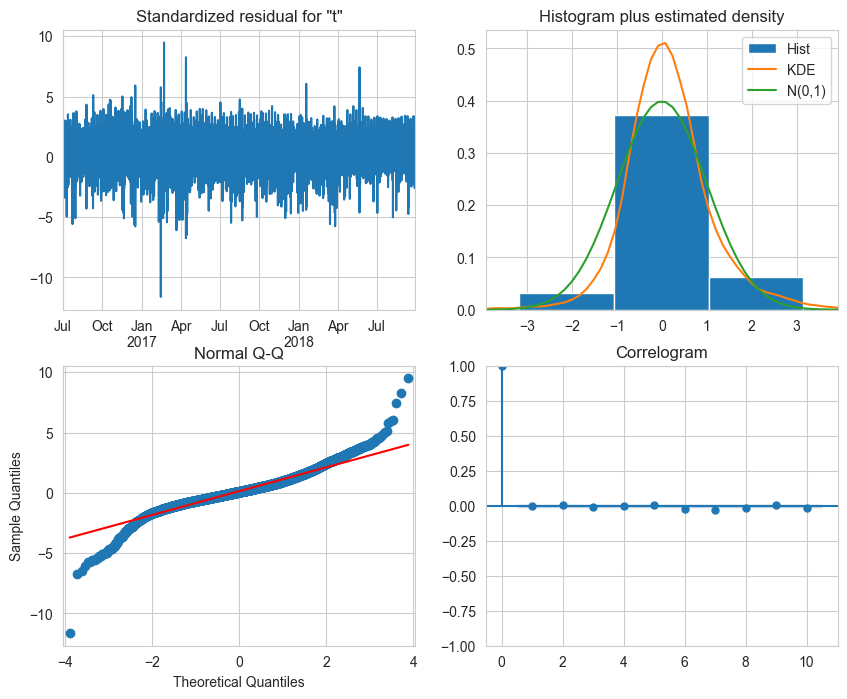

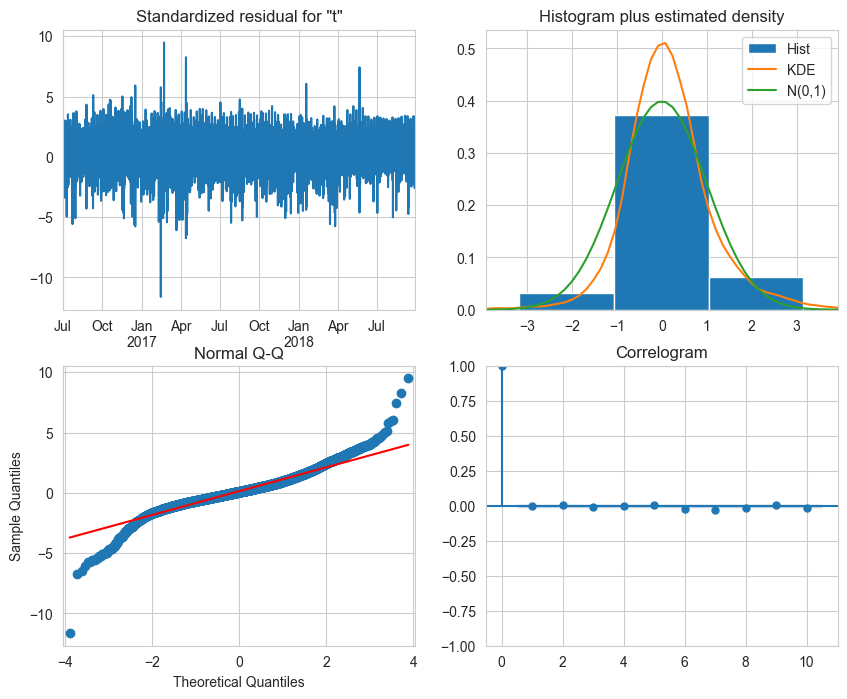

In [181]:
model = SARIMAX(train, order=(5,0,28),simple_differencing=False)

model_fit = model.fit(disp=False)

print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10,8))

In [182]:
def rolling_forecast(df,train_len, horizon, window, method):
    
    total_len = train_len + horizon
    end_idx = total_len
    
    if method == "mean":
        pred_mean = []
        
        for i in range(train_len,total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    elif method == "last":
        pred_last_value = []
        
        for i in range(train_len,total_len, window):
            last_value = df[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == "ARMA":
        pred_arma = []
        
        for i in range(train_len,total_len, window):
            model = SARIMAX(df[:i], order=(3,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0,i+ window -1)
            oos_pred = predictions.predicted_mean.iloc[-window]
            pred_arma.extend(oos_pred for _ in range(window))
        return pred_arma

In [469]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_ARMA = rolling_forecast(traffic_volume, TRAIN_LEN, HORIZON, WINDOW, "ARMA")
pred_last_value = rolling_forecast(traffic_volume, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_mean = rolling_forecast(traffic_volume, TRAIN_LEN, HORIZON, WINDOW, "mean")
test.loc[:, 'pred_ARMA'] = pred_ARMA
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_mean'] = pred_mean

TypeError: rolling_forecast() takes 4 positional arguments but 5 were given

In [186]:
test

traffic_volume  \
2018-09-28 00:00:00                                              699.0   
2018-09-28 01:00:00                                              461.0   
2018-09-28 02:00:00                                              301.0   
2018-09-28 03:00:00                                              367.0   
2018-09-28 04:00:00                                              870.0   
...                                                                ...   
2018-09-30 20:00:00                                             2781.0   
2018-09-30 21:00:00                                             2159.0   
2018-09-30 22:00:00                                             1450.0   
2018-09-30 23:00:00                                              954.0   
pred_ARMA            [1052.1813459409225, 1052.1813459409225, 492.2...   

                      pred_ARIMA  
2018-09-28 00:00:00  1052.181346  
2018-09-28 01:00:00   720.653318  
2018-09-28 02:00:00   492.241936  
2018-09-28 03:00:00     4.762060  
2018-09-28 04:00:00   342.806443  
...                          ...  
2018-09-30 20:00:00  3224.510026  
2018-09-30 21:00:00  2486.768864  
2018-09-30 22:00:00  1969.088477  
2018-09-30 23:00:00  1012.415871  
pred_ARMA             701.438509  

[73 rows x 2 columns]

<Axes: >

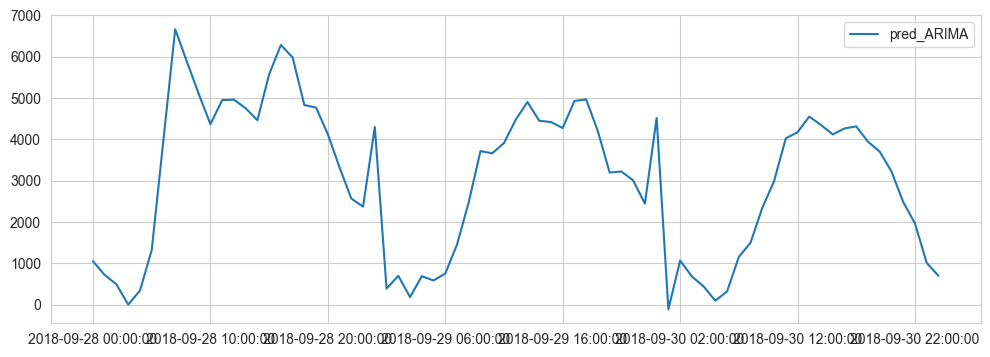

In [185]:
plt.rcParams['figure.figsize'] = [12,4]
test.plot('traffic')
plt.show()

In [ ]:
from sklearn.metrics import  mean_squared_error

mse_mean = mean_squared_error(test['traffic_volume'], test['pred_mean'])
mse_last = mean_squared_error(test['traffic_volume'], test['pred_last_value'])
mse_arma = mean_squared_error(test['traffic_volume'], test['pred_ARMA'])

print('MSE historical Mean', round(mse_mean, 3))
print('MSE last', round(mse_last, 3))
print('MSE ARMA', round(mse_arma, 3))

## Machine Learning Models

In [473]:
results_ml_val = pd.DataFrame(columns=['Model', 'Horizon','MAE', 'MSE', 'R2', 'RMSE'])
results_ml_test = pd.DataFrame(columns=['Model', 'Horizon', 'MAE', 'MSE', 'R2', 'RMSE'])

### Split the data

In [474]:
len_train = int(len(data_encoded) * 0.7)
len_val = int(len(data_encoded) * 0.15)
len_test = len(data_encoded) - len_train - len_val

train = data_encoded[:len_train]
val = data_encoded[len_train:len_train + len_val]
test = data_encoded[len_train + len_val:]

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")

Train size: 13809
Validation size: 2959
Test size: 2960


### Scaling the data

In [475]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

train_scaled_df = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
val_scaled_df = pd.DataFrame(val_scaled, index=val.index, columns=val.columns)
test_scaled_df = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

### Single-step forecast

#### Window

In [476]:
models = {
    "Linear Regression": LinearRegression(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regression": SVR(),
    "Bagging Regressor": BaggingRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}

In [477]:
WINDOW_IN = 12
HORIZON = 1    

train_windowed = slideWindow(train_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
val_windowed = slideWindow(val_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
test_windowed = slideWindow(test_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)

X_train = train_windowed.iloc[:, :-HORIZON].values  
y_train = train_windowed.iloc[:, -HORIZON:].values 

X_val = val_windowed.iloc[:, :-HORIZON].values
y_val = val_windowed.iloc[:, -HORIZON:].values

X_test = test_windowed.iloc[:, :-HORIZON].values
y_test = test_windowed.iloc[:, -HORIZON:].values

##### Train and evaluate the models

In [478]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_val, name, HORIZON, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon       MAE       MSE        R2      RMSE
0          Linear Regression        1  0.053752  0.005185  0.933283  0.072008
1       KNeighbors Regressor        1  0.027822  0.001956  0.974835  0.044224
2  Support Vector Regression        1  0.045797  0.003064  0.960577  0.055352
3          Bagging Regressor        1  0.025552  0.001552  0.980024  0.039401
4          Gradient Boosting        1  0.028441  0.001782  0.977072  0.042213
5              Decision Tree        1  0.033812  0.002805  0.963908  0.052962
6              Random Forest        1  0.024009  0.001360  0.982499  0.036880

Linear regressions has the lowest R squared score with 93.3%, showing that it struggled making right predictions when comparing with another models.

KNN outperforms the Linear Regression model having less error metrics and a higher R squared score.

SVR performs worse than the previous model, showing that it could not capture the complexity of the data as well as some other models.

Bagging Regressor got the second highest R squared score and low errors, showing that it is a strong contender when it comes to predicting the traffic volume.

Gradient Boosting is slightly outdone by KNN and demonstrates to be a good alternative.

Decision Tree is able to capture the data patterns better than the simpler model, Linear Regression. It has low performance when compared to the rest of the models.

Random Forest was the best performing model. This ensemble model got the highest R squared score and the lowest errors out of all models we tested.

In [479]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    y_test_pred = model.predict(X_test) 

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_test, name, HORIZON, mae, mse, r2, rmse)
    
results_ml_test

Model  Horizon       MAE       MSE        R2      RMSE
0          Linear Regression        1  0.047808  0.004316  0.938877  0.065696
1       KNeighbors Regressor        1  0.022843  0.001130  0.984002  0.033610
2  Support Vector Regression        1  0.038340  0.002179  0.969143  0.046678
3          Bagging Regressor        1  0.021773  0.001040  0.985273  0.032247
4          Gradient Boosting        1  0.024685  0.001292  0.981700  0.035947
5              Decision Tree        1  0.030414  0.002165  0.969341  0.046528
6              Random Forest        1  0.020273  0.000919  0.986980  0.030321

##### Hyperparameters

In [467]:
param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "KNeighbors Regressor": {
        "n_neighbors": [3],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "p": [1, 2]  
    },
    "Support Vector Regression": {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.5],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "Bagging Regressor": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "subsample": [0.8, 1.0]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["squared_error", "friedman_mse"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

In [468]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    param_combinations = list(product(*param_grid.values()))
    
    best_score = float("inf") 
    best_params = None
    best_model = None
    score_train = None
    
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))  
        
        model.set_params(**params)
        
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        mae_val = mean_absolute_error(y_val, y_val_pred)

        if mae_val < best_score:
            best_score = mae_val
            best_params = params
            best_model = model
            score_train = mean_absolute_error(y_train, y_train_pred)
            
    print(f"{model_name}: "
          f"- Score MAE Val = {best_score:.4f}"
          f"- Score MAE Train = {score_train:.4f}"
          f"- Melhores Parâmetros = {best_params}")


Linear Regression: - Score MAE Val = 0.0538- Score MAE Train = 0.0549- Melhores Parâmetros = {'fit_intercept': True}
KNeighbors Regressor: - Score MAE Val = 0.0286- Score MAE Train = 0.0000- Melhores Parâmetros = {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'p': 2}
Support Vector Regression: - Score MAE Val = 0.0240- Score MAE Train = 0.0236- Melhores Parâmetros = {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma': 'scale'}
Bagging Regressor: - Score MAE Val = 0.0239- Score MAE Train = 0.0152- Melhores Parâmetros = {'n_estimators': 100, 'max_samples': 0.5, 'bootstrap': True, 'bootstrap_features': False}
Gradient Boosting: - Score MAE Val = 0.0241- Score MAE Train = 0.0206- Melhores Parâmetros = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
Decision Tree: - Score MAE Val = 0.0288- Score MAE Train = 0.0221- Melhores Parâmetros = {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
Random Forest: 

In [480]:
models_hyper = {
    "Linear Regression": LinearRegression(fit_intercept=True),
    "KNeighbors Regressor": KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2),
    "Support Vector Regression": SVR(C=10, epsilon=0.01, kernel='rbf', gamma='scale'),
    "Bagging Regressor": BaggingRegressor(n_estimators=100, max_samples=0.5, bootstrap=True, bootstrap_features=False),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=2, min_samples_leaf=1, criterion='squared_error'),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=4),
}

In [481]:
HORIZON

1

In [482]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_val, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon       MAE       MSE  \
0                             Linear Regression        1  0.053752  0.005185   
1                          KNeighbors Regressor        1  0.027822  0.001956   
2                     Support Vector Regression        1  0.045797  0.003064   
3                             Bagging Regressor        1  0.025552  0.001552   
4                             Gradient Boosting        1  0.028441  0.001782   
5                                 Decision Tree        1  0.033812  0.002805   
6                                 Random Forest        1  0.024009  0.001360   
7           Linear Regression - Hyperparameters        1  0.053752  0.005185   
8        KNeighbors Regressor - Hyperparameters        1  0.028570  0.002065   
9   Support Vector Regression - Hyperparameters        1  0.024050  0.001455   
10          Bagging Regressor - Hyperparameters        1  0.023957  0.001347   
11          Gradient Boosting - Hyperparameters        1  0.024507  0.001392   
12              Decision Tree - Hyperparameters        1  0.028798  0.001986   
13              Random Forest - Hyperparameters        1  0.023783  0.001340   

          R2      RMSE  
0   0.933283  0.072008  
1   0.974835  0.044224  
2   0.960577  0.055352  
3   0.980024  0.039401  
4   0.977072  0.042213  
5   0.963908  0.052962  
6   0.982499  0.036880  
7   0.933283  0.072008  
8   0.973436  0.045437  
9   0.981279  0.038143  
10  0.982674  0.036695  
11  0.982090  0.037308  
12  0.974445  0.044565  
13  0.982755  0.036609

In [483]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_test, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)
    
results_ml_test

Model  Horizon       MAE       MSE  \
0                             Linear Regression        1  0.047808  0.004316   
1                          KNeighbors Regressor        1  0.022843  0.001130   
2                     Support Vector Regression        1  0.038340  0.002179   
3                             Bagging Regressor        1  0.021773  0.001040   
4                             Gradient Boosting        1  0.024685  0.001292   
5                                 Decision Tree        1  0.030414  0.002165   
6                                 Random Forest        1  0.020273  0.000919   
7           Linear Regression - Hyperparameters        1  0.047808  0.004316   
8        KNeighbors Regressor - Hyperparameters        1  0.024336  0.001275   
9   Support Vector Regression - Hyperparameters        1  0.020756  0.000941   
10          Bagging Regressor - Hyperparameters        1  0.020051  0.000910   
11          Gradient Boosting - Hyperparameters        1  0.021569  0.000978   
12              Decision Tree - Hyperparameters        1  0.025065  0.001495   
13              Random Forest - Hyperparameters        1  0.020124  0.000913   

          R2      RMSE  
0   0.938877  0.065696  
1   0.984002  0.033610  
2   0.969143  0.046678  
3   0.985273  0.032247  
4   0.981700  0.035947  
5   0.969341  0.046528  
6   0.986980  0.030321  
7   0.938877  0.065696  
8   0.981944  0.035707  
9   0.986669  0.030681  
10  0.987114  0.030165  
11  0.986156  0.031266  
12  0.978821  0.038671  
13  0.987070  0.030216

In [487]:
filtered_results = results_ml_val[
    (results_ml_val['Horizon'] == HORIZON) & 
    (results_ml_val['Model'].str.contains('Hyperparameters')) 
]

best_model_df = filtered_results.loc[filtered_results['MAE'].idxmin()]

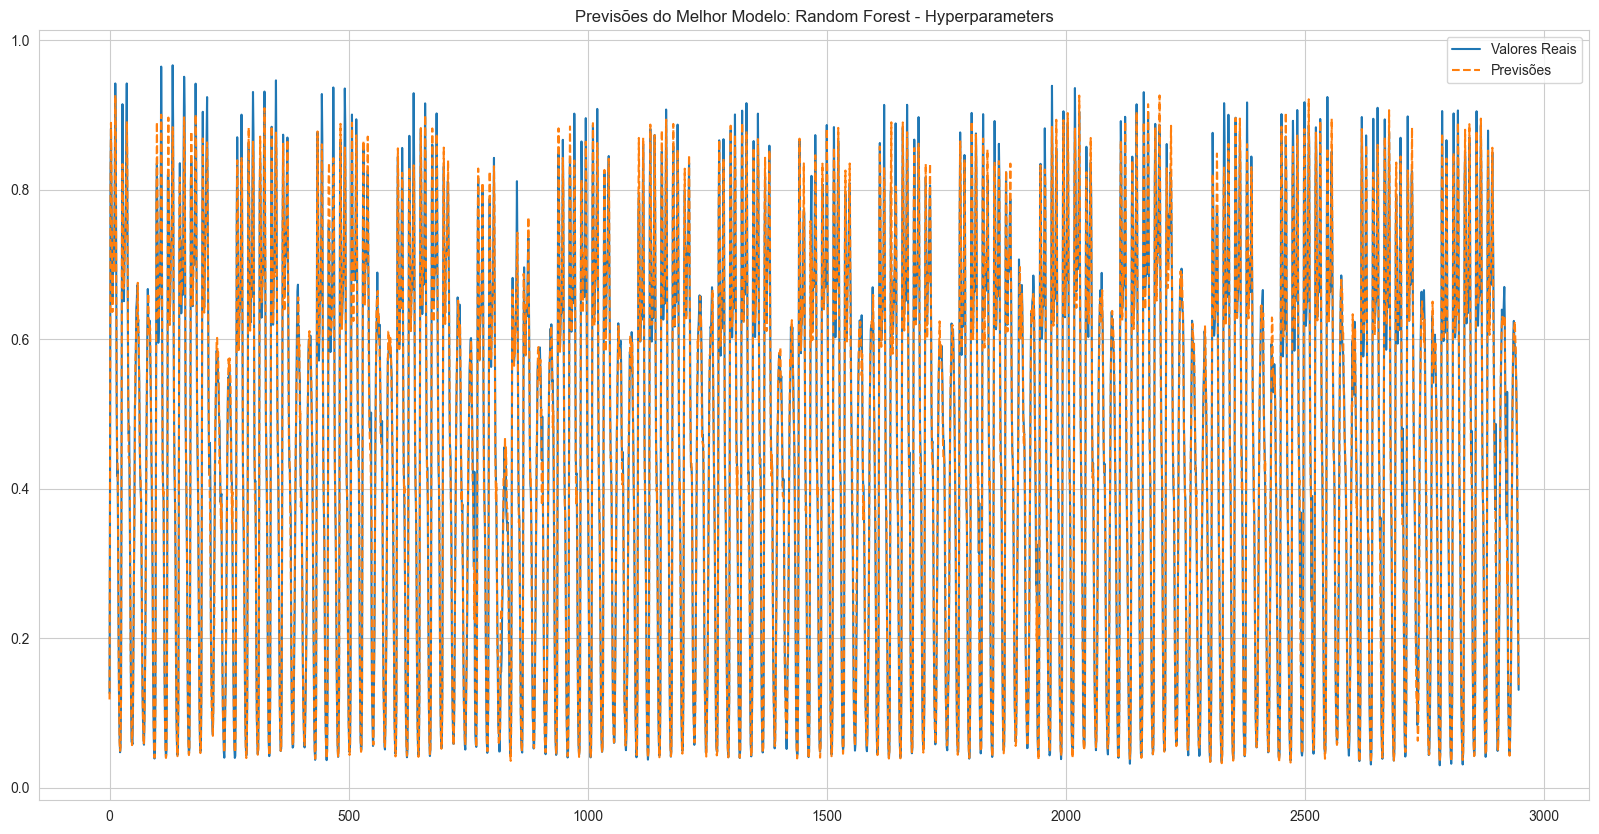

In [494]:
# Previsões do conjunto de teste

name = best_model_df['Model']

name_without_hyperparams = name.replace(' - Hyperparameters', '')

best_model = models_hyper[name_without_hyperparams]
best_model.fit(X_train, y_train.ravel())
y_test_pred = best_model.predict(X_test)

plt.figure(figsize=(20, 10))
plt.plot(y_test, label="Valores Reais")
plt.plot(y_test_pred, label="Previsões", linestyle="dashed")
plt.title(f"Previsões do Melhor Modelo: {best_model_df['Model']}")
plt.legend()
plt.show()

As we can see by the graph, the predictions of the Random Forest are very close to the real values. We can conclude that this model is an excellent choice by capturing the underlying patterns of the data due to its ensemble nature, which combines multiple decision trees to reduce variance and improve generalization. This strong performance is further evidenced by the high R² score (0.9870) and low error metrics (MAE and RMSE), both on the validation and test sets.

#### Without Window

### Multi-step forecast

#### Window

In [495]:
models = {
    "Linear Regression": LinearRegression(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Bagging Regressor": BaggingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}

In [496]:
WINDOW_IN = 24  
HORIZON = 4  

train_windowed = slideWindow(train_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
val_windowed = slideWindow(val_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)
test_windowed = slideWindow(test_scaled_df[['traffic_volume']], WINDOW_IN, HORIZON)

X_train = train_windowed.iloc[:, :-HORIZON].values 
y_train = train_windowed.iloc[:, -HORIZON:].values  

X_val = val_windowed.iloc[:, :-HORIZON].values
y_val = val_windowed.iloc[:, -HORIZON:].values

X_test = test_windowed.iloc[:, :-HORIZON].values
y_test = test_windowed.iloc[:, -HORIZON:].values

## Train and evaluate the models

In [497]:
for name, model in models.items():
    model.fit(X_train, y_train) 
    
    y_val_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    
    add_results(results_ml_val,name, HORIZON, mae, mse, r2, rmse)
    
results_ml_val

Model  Horizon       MAE       MSE  \
0                             Linear Regression        1  0.053752  0.005185   
1                          KNeighbors Regressor        1  0.027822  0.001956   
2                     Support Vector Regression        1  0.045797  0.003064   
3                             Bagging Regressor        1  0.025552  0.001552   
4                             Gradient Boosting        1  0.028441  0.001782   
5                                 Decision Tree        1  0.033812  0.002805   
6                                 Random Forest        1  0.024009  0.001360   
7           Linear Regression - Hyperparameters        1  0.053752  0.005185   
8        KNeighbors Regressor - Hyperparameters        1  0.028570  0.002065   
9   Support Vector Regression - Hyperparameters        1  0.024050  0.001455   
10          Bagging Regressor - Hyperparameters        1  0.023957  0.001347   
11          Gradient Boosting - Hyperparameters        1  0.024507  0.001392   
12              Decision Tree - Hyperparameters        1  0.028798  0.001986   
13              Random Forest - Hyperparameters        1  0.023783  0.001340   
14                            Linear Regression        4  0.069101  0.011331   
15                         KNeighbors Regressor        4  0.035044  0.003956   
16                            Bagging Regressor        4  0.033919  0.003342   
17                                Decision Tree        4  0.044752  0.006065   
18                                Random Forest        4  0.032052  0.002899   

          R2      RMSE  
0   0.933283  0.072008  
1   0.974835  0.044224  
2   0.960577  0.055352  
3   0.980024  0.039401  
4   0.977072  0.042213  
5   0.963908  0.052962  
6   0.982499  0.036880  
7   0.933283  0.072008  
8   0.973436  0.045437  
9   0.981279  0.038143  
10  0.982674  0.036695  
11  0.982090  0.037308  
12  0.974445  0.044565  
13  0.982755  0.036609  
14  0.854229  0.106447  
15  0.949100  0.062899  
16  0.957003  0.057812  
17  0.921970  0.077877  
18  0.962700  0.053845

In [498]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_test, name, HORIZON, mae, mse, r2, rmse)

results_ml_test

Model  Horizon       MAE       MSE  \
0                             Linear Regression        1  0.047808  0.004316   
1                          KNeighbors Regressor        1  0.022843  0.001130   
2                     Support Vector Regression        1  0.038340  0.002179   
3                             Bagging Regressor        1  0.021773  0.001040   
4                             Gradient Boosting        1  0.024685  0.001292   
5                                 Decision Tree        1  0.030414  0.002165   
6                                 Random Forest        1  0.020273  0.000919   
7           Linear Regression - Hyperparameters        1  0.047808  0.004316   
8        KNeighbors Regressor - Hyperparameters        1  0.024336  0.001275   
9   Support Vector Regression - Hyperparameters        1  0.020756  0.000941   
10          Bagging Regressor - Hyperparameters        1  0.020051  0.000910   
11          Gradient Boosting - Hyperparameters        1  0.021569  0.000978   
12              Decision Tree - Hyperparameters        1  0.025065  0.001495   
13              Random Forest - Hyperparameters        1  0.020124  0.000913   
14                            Linear Regression        4  0.060319  0.009450   
15                         KNeighbors Regressor        4  0.025661  0.001623   
16                            Bagging Regressor        4  0.025055  0.001476   
17                                Decision Tree        4  0.036071  0.003370   
18                                Random Forest        4  0.023318  0.001251   

          R2      RMSE  
0   0.938877  0.065696  
1   0.984002  0.033610  
2   0.969143  0.046678  
3   0.985273  0.032247  
4   0.981700  0.035947  
5   0.969341  0.046528  
6   0.986980  0.030321  
7   0.938877  0.065696  
8   0.981944  0.035707  
9   0.986669  0.030681  
10  0.987114  0.030165  
11  0.986156  0.031266  
12  0.978821  0.038671  
13  0.987070  0.030216  
14  0.865894  0.097213  
15  0.976976  0.040283  
16  0.979063  0.038413  
17  0.952186  0.058050  
18  0.982253  0.035366

##### Hyperparameters

In [499]:
param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },
    "KNeighbors Regressor": {
        "n_neighbors": [3, 5],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "p": [1, 2]  
    },
    "Bagging Regressor": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["squared_error", "friedman_mse"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

In [455]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    param_combinations = list(product(*param_grid.values()))
    
    best_score = float("inf") 
    best_params = None
    best_model = None
    score_train = None
    
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))  
        
        model.set_params(**params)
        
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        mae_val = mean_absolute_error(y_val, y_val_pred)

        if mae_val < best_score:
            best_score = mae_val
            best_params = params
            best_model = model
            score_train = mean_absolute_error(y_train, y_train_pred)
        
    print(f"{model_name}: "
      f"- Score MAE Val = {best_score:.4f}"
      f"- Score MAE Train = {score_train:.4f}"
      f"- Melhores Parâmetros = {best_params}")   

Decision Tree: Melhor MAE = 0.0388, Melhores Parâmetros = {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'squared_error'}, Score Train = 0.0305
Random Forest: Melhor MAE = 0.0319, Melhores Parâmetros = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}, Score Train = 0.0125


In [ ]:
break

In [ ]:
models_hyper = {
    "Linear Regression": LinearRegression(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Bagging Regressor": BaggingRegressor(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2, criterion='squared_error'),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1),
}

In [ ]:
for name, model in models_hyper.items():
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    rmse = np.sqrt(mse)

    add_results(results_ml_val, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)
    
results_ml_val

In [ ]:

for name, model in models_hyper.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mse_test)

    add_results(results_ml_test, f"{name} - Hyperparameters", HORIZON, mae, mse, r2, rmse)

results_ml_test

When comparing to previous results we can see that the results drastically got worse. This is due to the use of recursive multi-step forecast strategy used in which the model uses its own past estimated values to make predictions. The accumulation of errors leads to reduced performance as evidenced by the results.

The linear regression performed the worst out of all models just like in the single step forecast.

This time the KNN was the one that performed the best. It's ability to make predictions based on similarity of nearby data points makes it more robust to propagation of errors, despite still being affected.

SVR performed poorly just like time, being one of the worse model we tested.

Bagging Regressor got a good relative score. Its R squared score and errors were close to KNN that had the best results.

Gradient Boosting did not improve relative of the other models, since it was outperformed by many others just like the previous forecast.

Decision Trees managed to get a good comparative R squared score that shows their ability to model non-linear relationships and interactions between features effectively.

Random forest did not get a good performance for this task, being outperformed by KNN, altough both have similar scores and errors.

This results show that these models may not be a suitable option for multi-step forecast using recursion. Since not all are compatible with the direct strategy we chose to only test this approach on the best performing one. When comparing the two different methods we can see a very big difference since the R squared improved drastically. All the errors lowered and we got a performance that is comparable with the results of the single step forecast.

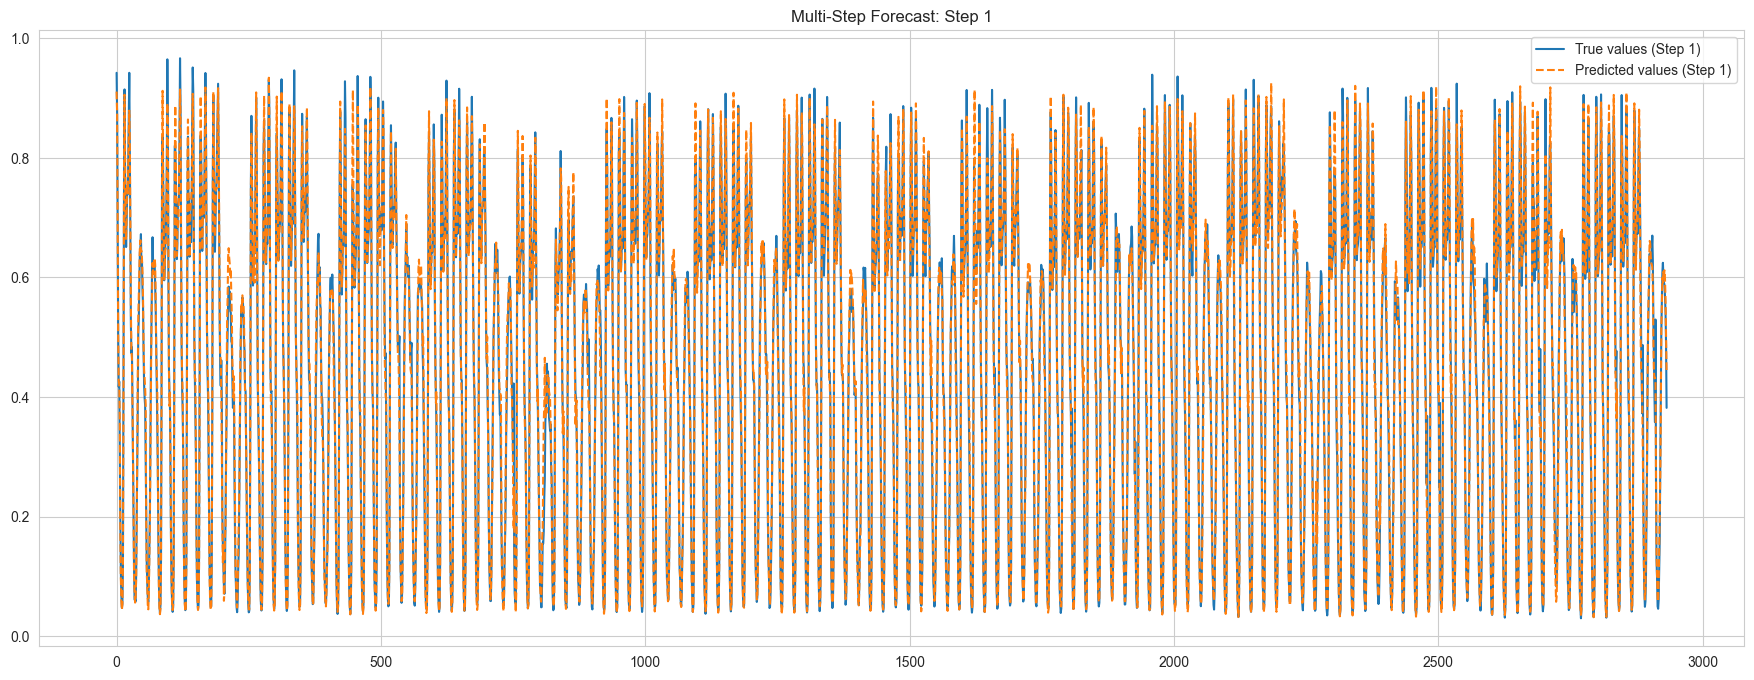

MAE: 0.022215580192054794


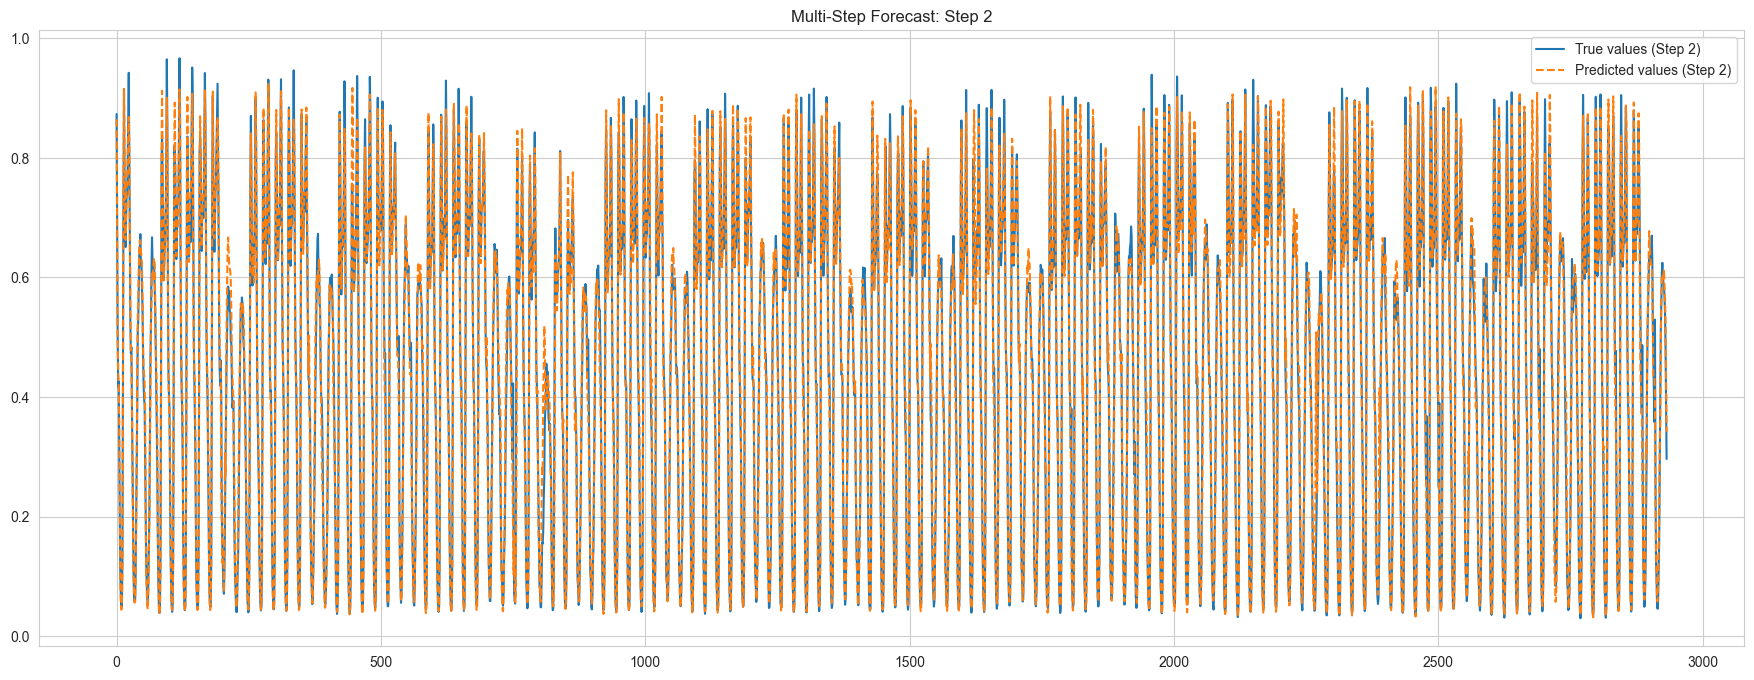

MAE: 0.025087700400520038


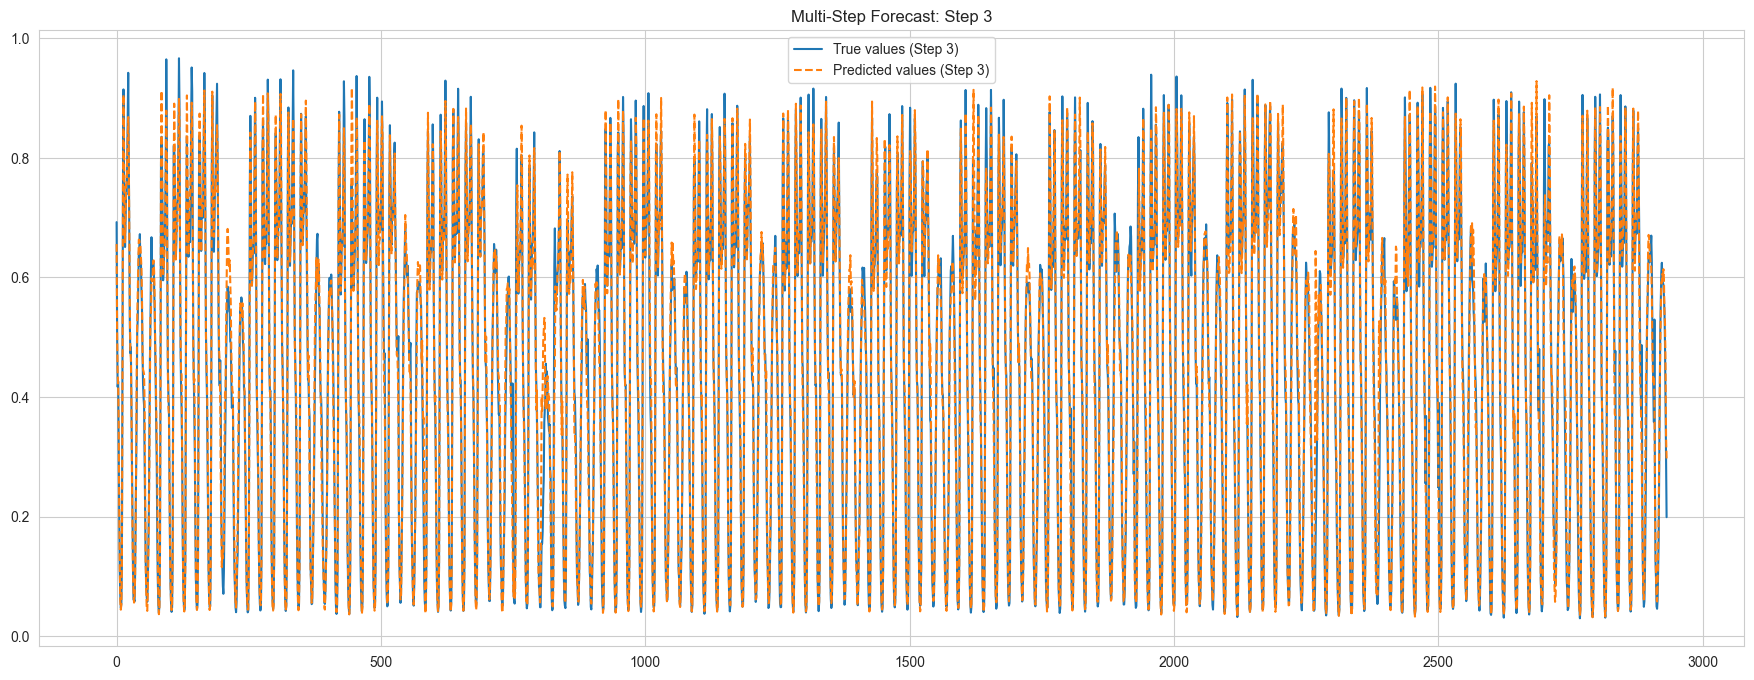

MAE: 0.026559911278629313


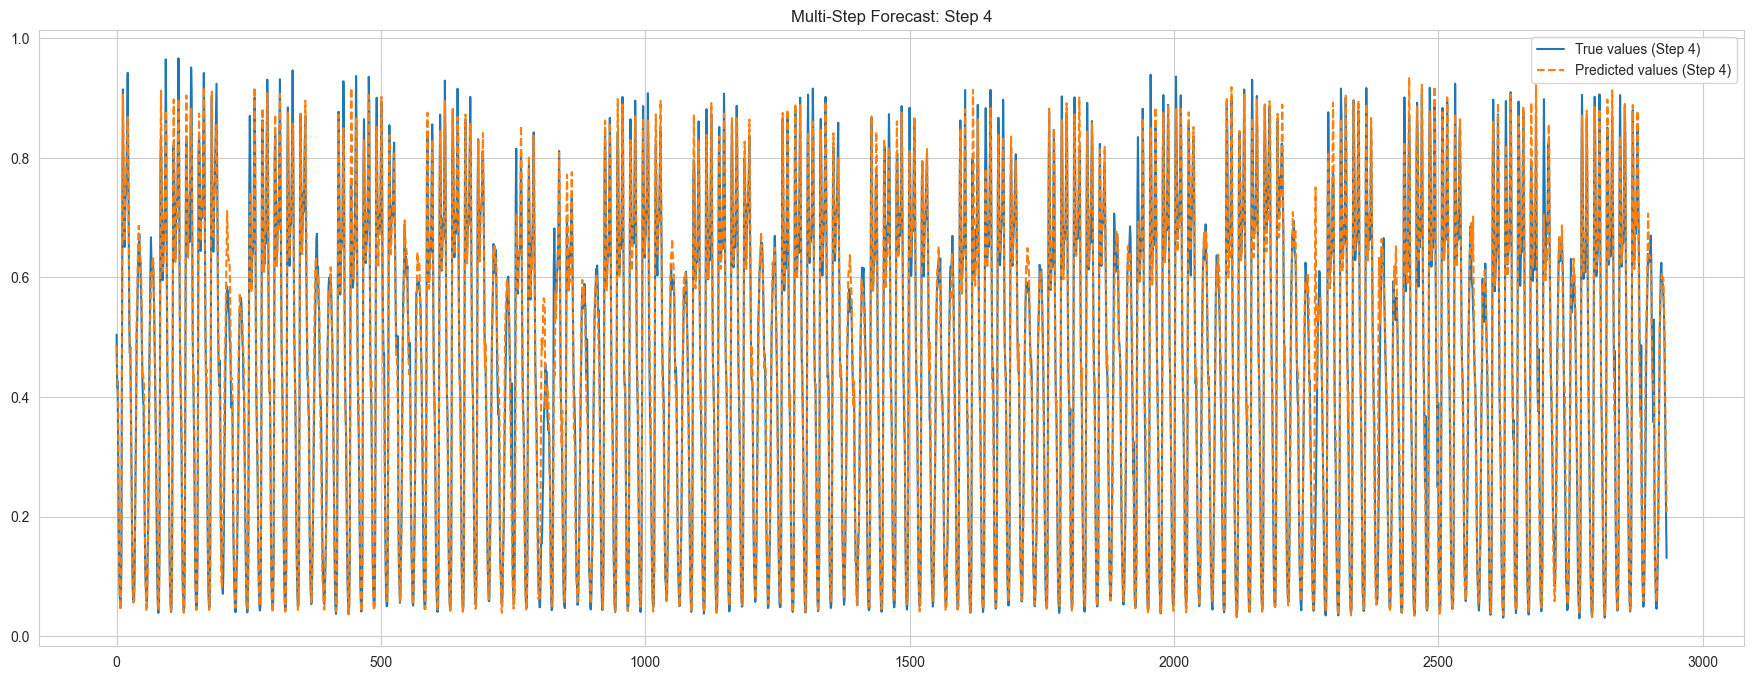

MAE: 0.02763335369029198


In [313]:
filtered_results = results_ml_val[
    (results_ml_val['Horizon'] == HORIZON) &
    (results_ml_val['Model'].str.contains('Hyperparameters'))
    ]

best_model_df = filtered_results.loc[filtered_results['MAE'].idxmin()]

name = best_model_df['Model']

name_without_hyperparams = name.replace(' - Hyperparameters', '')

best_model = models_hyper[name_without_hyperparams]
best_model.fit(X_train, y_train.ravel())
y_test_pred = best_model.predict(X_test)

for step in range(HORIZON):
    plt.figure(figsize=(22, 8))
    plt.plot(y_test[:, step], label=f"True values (Step {step+1})")
    plt.plot(y_test_pred[:, step], label=f"Predicted values (Step {step+1})", linestyle="dashed")
    plt.title(f"Multi-Step Forecast: Step {step+1}")
    plt.legend()
    plt.show()
    print("MAE:",mean_absolute_error(y_test[:, step], y_test_pred[:, step]))


As we can see from the predictions vs actual values of the traffic volume, the model performed significantly better when using the direct strategy compared to the recursive multi-step forecast strategy. The direct approach trains the model separately for each forecasting horizon, avoiding the accumulation of errors that often occurs in recursive strategies. This results in more accurate and stable predictions for each time step despite the MAE error getting slighly bigger by each horizon step.

### Deep learning models

#### LSTM

Since the data shows clear cycles and trends we opted to only use recent data to train the model. This way we get simpler models while still being able to capture its patterns.

In [369]:
from scalecast.Forecaster import Forecaster

# Focus on the last 3 months of data for clearer plots
data_encoded_truncated = data_encoded.iloc[-1 * 30 * 24:]  # Last 3 months, assuming 30 days per month and hourly data
f = Forecaster(y=data_encoded_truncated['traffic_volume'], current_dates=data_encoded_truncated.index, metrics = ['rmse','mape','mae','r2'],
)

In [371]:
from scalecast.util import metrics
def rmse_mae(a,f):
    # average of rmse and mae
    return (metrics.rmse(a,f) + metrics.mae(a,f)) / 2

f.set_test_length(12)       # 1. 12 observations to test the results
f.generate_future_dates(12) # 2. 12 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network
f.add_metric(rmse_mae, called='mae')

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.3723 - val_loss: 0.2668
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2508 - val_loss: 0.1850
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1799 - val_loss: 0.1522
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1511 - val_loss: 0.1303
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1399 - val_loss: 0.1231
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1237 - val_loss: 0.1123
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1213 - val_loss: 0.1169
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1177 - val_loss: 0.1082
Epoch 9/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1151 - val_loss: 0.1029
Epoch 10/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1138 - val_loss: 0.0996
Epoch 11/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1060 - val_loss: 0.0997
Epoch 12/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

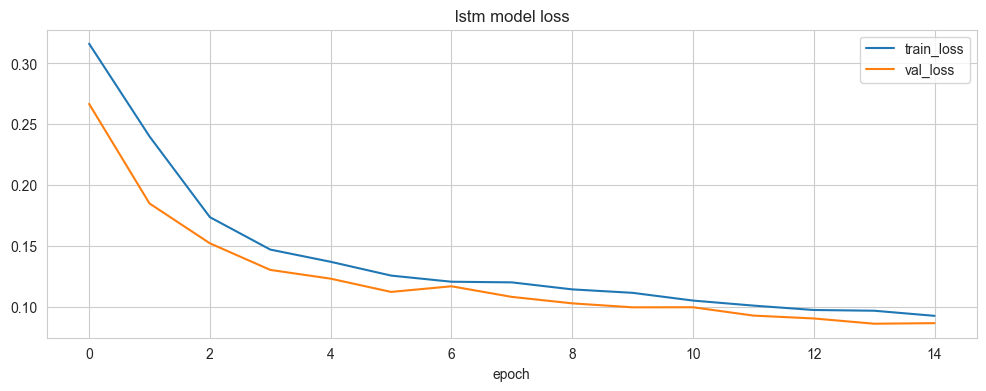

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.3854 - val_loss: 0.2803
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2628 - val_loss: 0.2388
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.2262 - val_loss: 0.1491
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1604 - val_loss: 0.1278
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1428 - val_loss: 0.1277
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1320 - val_loss: 0.1215
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1224 - val_loss: 0.1058
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1158 - val_loss: 0.1014
Epoch 9/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1139 - val_loss: 0.1015
Epoch 10/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1093 - val_loss: 0.0961
Epoch 11/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1090 - val_loss: 0.1057
Epoch 12/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1

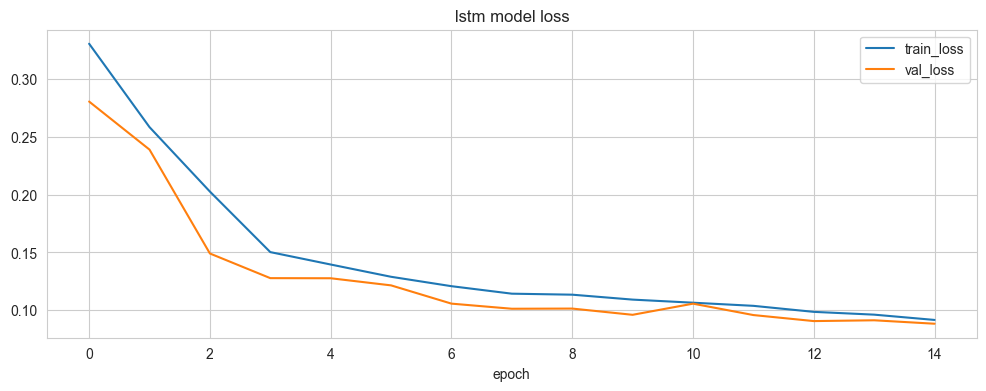

<Axes: xlabel='Date', ylabel='Values'>

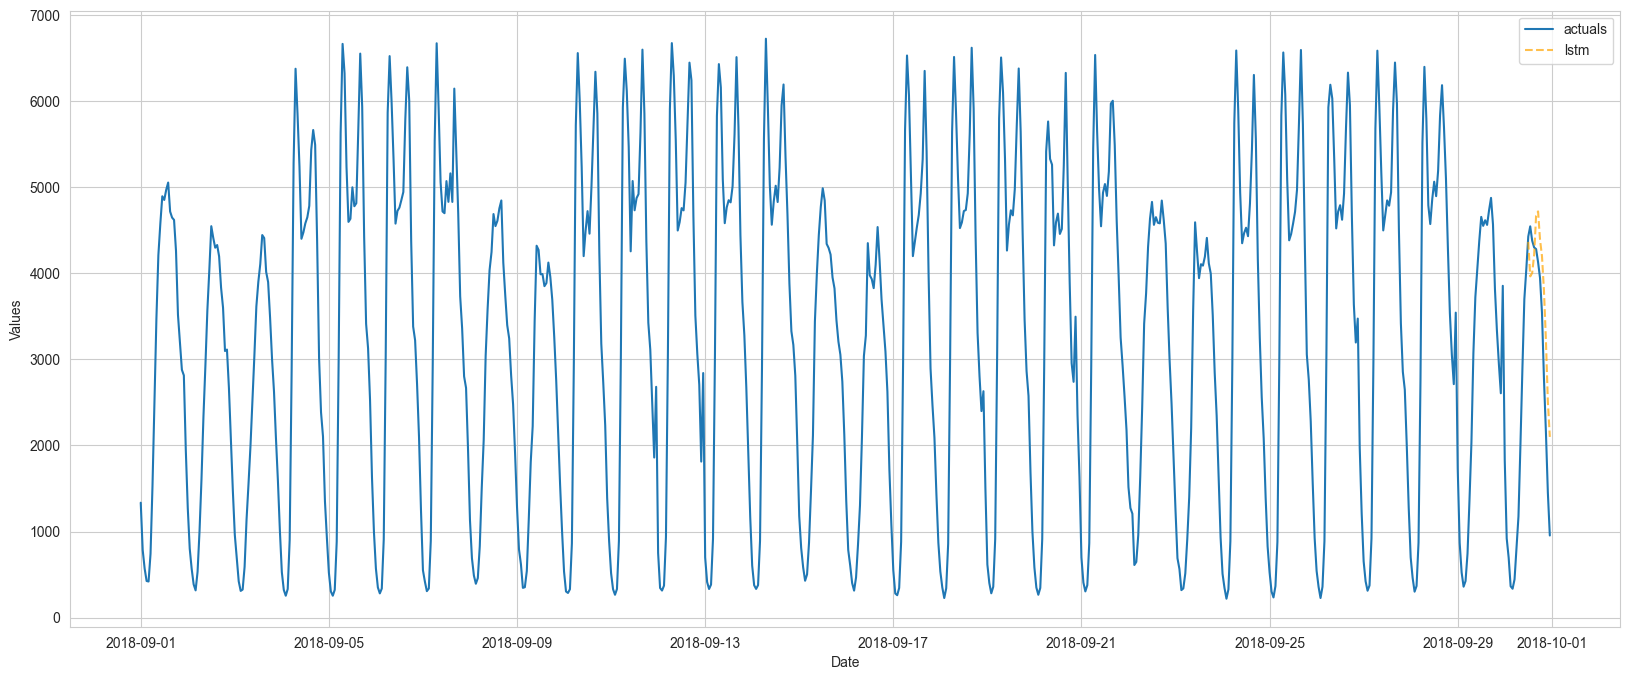

In [372]:
f.manual_forecast(
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True,
)
f.plot_test_set(ci=True, figsize=(20,8))

We can observe that we managed to obtain hyperparameters that led to good results. By examining the train and validation losses, we conclude that the model did not overfit, as both metrics showed a steady decrease without the validation loss increasing while training continued. They both converged to similar values, which indicates that the model was able to generalize well. Additionally, we successfully predicted 12 timesteps ahead, demonstrating that the model can effectively capture the temporal dependencies in the data for multi-step forecasting.

In [385]:
f.export(dfs='model_summaries',determine_best_by='TestSetMAPE')

ModelNickname Estimator                                              Xvars  \
0          lstm      lstm  [AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR9, ...   

                                         HyperParams  Observations  \
0  {'batch_size': 32, 'epochs': 15, 'validation_s...           720   

   DynamicallyTested  TestSetLength  CILevel  ValidationMetric  \
0               True             12      NaN               NaN   

   ValidationMetricValue  ...  weights  best_model  InSampleRMSE  \
0                    NaN  ...      NaN        True     758.92876   

   InSampleMAPE  InSampleMAE  InSampleR2  TestSetRMSE  TestSetMAPE  \
0      0.256673   637.231503    0.848238   721.669769     0.297916   

   TestSetMAE  TestSetR2  
0  672.714746   0.642698  

[1 rows x 21 columns]

When looking at the metrics it looks like the results were not as good as they seemed. The R2 score was lower than in previous multi step predictions with the RMSE and MAE of the test set being too large. We can observe a considerable dip in score when comparing the Sample R squared to the test one. In summary, while the model is performing reasonably well, especially in the training phase, it seems to struggle with generalizing to the test data.

In [392]:
# corrigir

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

HORIZON = 1
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(2000, 1)))
model.add(Dense(HORIZON))

model.compile(optimizer='RMSprop', loss='mse')
model.summary()
GRU_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
model_history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_val, y_val),callbacks=[GRU_earlystop],verbose=1)

y_pred = model.predict(X_test)
y_pred


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0876 - val_loss: 0.0369
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0335 - val_loss: 0.0328
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0310 - val_loss: 0.0313
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0293 - val_loss: 0.0301
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0279 - val_loss: 0.0290
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0267 - val_loss: 0.0277
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0258 - val_loss: 0.0262
Epoch 8/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0245 - val_loss: 0.0253
Epoch 9/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0236 - val_loss: 0.0244
Epoch 10/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0230 - val_loss: 0.0236
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[0.6584271 ],
       [0.69887257],
       [0.62951523],
       ...,
       [0.4605796 ],
       [0.41103968],
       [0.33637425]], dtype=float32)

In [396]:
r2_score(y_test[:,0], y_pred)

0.7618003297421467

In [387]:
break

SyntaxError: 'break' outside loop (370545404.py, line 1)

In [271]:
X_train

array([[0.11332418, 0.07293956, 0.05233516, ..., 0.36085165, 0.34313187,
        0.27293956],
       [0.07293956, 0.05233516, 0.05576923, ..., 0.34313187, 0.27293956,
        0.16950549],
       [0.05233516, 0.05576923, 0.10851648, ..., 0.27293956, 0.16950549,
        0.12912088],
       ...,
       [0.06593407, 0.13543956, 0.3875    , ..., 0.15398352, 0.09230769,
        0.06538462],
       [0.13543956, 0.3875    , 0.7114011 , ..., 0.09230769, 0.06538462,
        0.05123626],
       [0.3875    , 0.7114011 , 0.83228022, ..., 0.06538462, 0.05123626,
        0.06167582]])

In [272]:
y_train

array([[0.16950549, 0.12912088, 0.09120879, 0.05123626],
       [0.12912088, 0.09120879, 0.05123626, 0.05837912],
       [0.09120879, 0.05123626, 0.05837912, 0.09326923],
       ...,
       [0.05123626, 0.06167582, 0.10343407, 0.18928571],
       [0.06167582, 0.10343407, 0.18928571, 0.29642857],
       [0.10343407, 0.18928571, 0.29642857, 0.39120879]])

# End ----------------------------------------------

In [ ]:
data.groupby(['date_time']).size().sort_values(ascending=False)

In [ ]:
data[data['date_time']== '2018-09-20 19:00:00']

In [ ]:
23622-19608

## Univariate Analysis

In [ ]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

In [ ]:
boxplot_visualization(data, numerical_columns,"Boxplot")

In [ ]:
data['holiday'].unique()

Since we have 11 different holidays and only 31 rows represent a non-null value, we decided to take a look on the values since the dataset has 24 different values for each day, which means that we should have a lot more filled values. We discovered that only the first hour of the holiday was correctly filled.

In [ ]:
data['weather_main'].unique()

We have 11 different weather conditions that may influence the traffic
Since the description is directly associated with the weather condition we will look into the possibility of extracting insights from this column.

In [ ]:
data['weather_description'].nunique()

We have 37 different descriptions

In [ ]:
data[['weather_main', 'weather_description']].groupby('weather_main')['weather_description'].nunique()

Each weather condition can have up to seven different descriptions, we will check what are they

In [ ]:
unique_descriptions = data.groupby('weather_main')['weather_description'].unique()

for weather, descriptions in unique_descriptions.items():
    print(f"{weather}: {list(descriptions)}")

After analyzing all the different descriptions we decided to group them based on their intensity and how they affect the visibility and driving condition.
We will also correct some inconsistencies to keep uniformity throughout the descriptions.
This is our proposed values for the new grouped column:

1 - **Total Visibility (No Impact)**  
- *sky is clear*  

2 - **Slight Visibility Reduction (Low Intensity)**  
- *few clouds*
- *scattered clouds*  
- *mist*
- *haze*  
- *light intensity drizzle*
- *drizzle*
- *light intensity shower rain*
- *light rain*  
- *light snow*
- *light shower snow*  

3 - **Moderate Visibility Reduction (Moderate Intensity)**  
- *broken clouds*
- *overcast clouds*  
- *fog*  
- *moderate rain*
- *shower drizzle*
- *proximity shower rain*
- *snow*
- *light rain and snow*
- *sleet*  
- *proximity thunderstorm*
- *thunderstorm with light rain*
- *thunderstorm with drizzle*  
- *proximity thunderstorm with drizzle*
- *thunderstorm with light drizzle*

4 - **Significant Visibility Reduction (High Intensity)**  
- *heavy intensity drizzle*
- *heavy intensity rain*
- *very heavy rain*  
- *heavy snow*  
- *freezing rain* 
- *smoke* 
- *thunderstorm*
- *thunderstorm with rain*
- *proximity thunderstorm with rain*  

5 - **Extreme Visibility Reduction (Very High Intensity)**  
- *thunderstorm with heavy rain*
- *SQUALLS*  


In [ ]:
def categorize_visibility_and_intensity(description):
    if description in ['sky is clear']:
        return 1
    
    elif description in ['few clouds', 'scattered clouds', 'mist', 'haze','light intensity drizzle', 'drizzle', 'light intensity shower rain', 'light rain', 'light snow', 'light shower snow']:
        return 2
    
    elif description in ['broken clouds', 'overcast clouds', 'fog', 'moderate rain','shower drizzle', 'proximity shower rain', 'snow', 'light rain and snow', 'sleet', 'proximity thunderstorm', 'thunderstorm with light rain', 'thunderstorm with drizzle','proximity thunderstorm with drizzle', 'thunderstorm with light drizzle']:
        return 3
    
    elif description in ['heavy intensity drizzle', 'heavy intensity rain', 'very heavy rain', 'heavy snow', 'freezing rain', 'smoke', 'thunderstorm','thunderstorm with rain', 'proximity thunderstorm with rain']:
        return 4
    
    elif description in ['thunderstorm with heavy rain', 'SQUALLS']:
        return 5
    
    else:
        return 'Unknown'

In [ ]:
data['weather_description'] = data['weather_description'].replace('Sky is Clear', 'sky is clear')

In [ ]:
data['visibility_level'] = data['weather_description'].apply(categorize_visibility_and_intensity)

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data['traffic_volume'], bins=50, kde=True)
plt.title('Distribuição do Volume de Tráfego')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data_m['date_time'], data_m['traffic_volume'], )
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=data['weather_main'], y=data['traffic_volume'])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=data['weather_description'], y=data['traffic_volume'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
data['holiday'] = data['holiday'].fillna('No holiday')

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=data['holiday'], y=data['traffic_volume'], gap=0.5)
plt.xticks(rotation=45)
plt.show()

In [ ]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [ ]:
data

In [ ]:
#data = data.set_index('date_time')

# Ajustar a frequência para hora ('H')
data.index.freq = 'h'

# Verificar o índice
print(data.index)

In [ ]:
data

In [ ]:
start_date = data.index.min()
end_date = data.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='h')

missing_dates = date_range.difference(data.index)

In [ ]:
missing_dates